# Correlation Analysis

Correlation analysis reveals relationships between features, identifies multicollinearity, and guides feature grouping for dimensionality reduction.


In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import display

from ama_tlbx.analysis import suggest_groups_from_correlation
from ama_tlbx.data import LifeExpectancyDataset, LECol
from ama_tlbx.plotting.correlation_plots import (
    plot_correlation_heatmap,
    plot_top_correlated_pairs,
    plot_target_correlations,
)

np.random.seed(42)

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["figure.labelsize"] = 11
plt.rcParams["figure.titleweight"] = "bold"


In [38]:
# le_ds = LifeExpectancyDataset.from_csv(aggregate_by_country=False)
le_ds = LifeExpectancyDataset.from_csv(
    aggregate_by_country=2014, resolve_nand_pred="drop"
)


corr_result = le_ds.make_correlation_analyzer().fit().result()


## 1. Correlation Matrix Heatmap

Shows pairwise correlations between all numeric features.

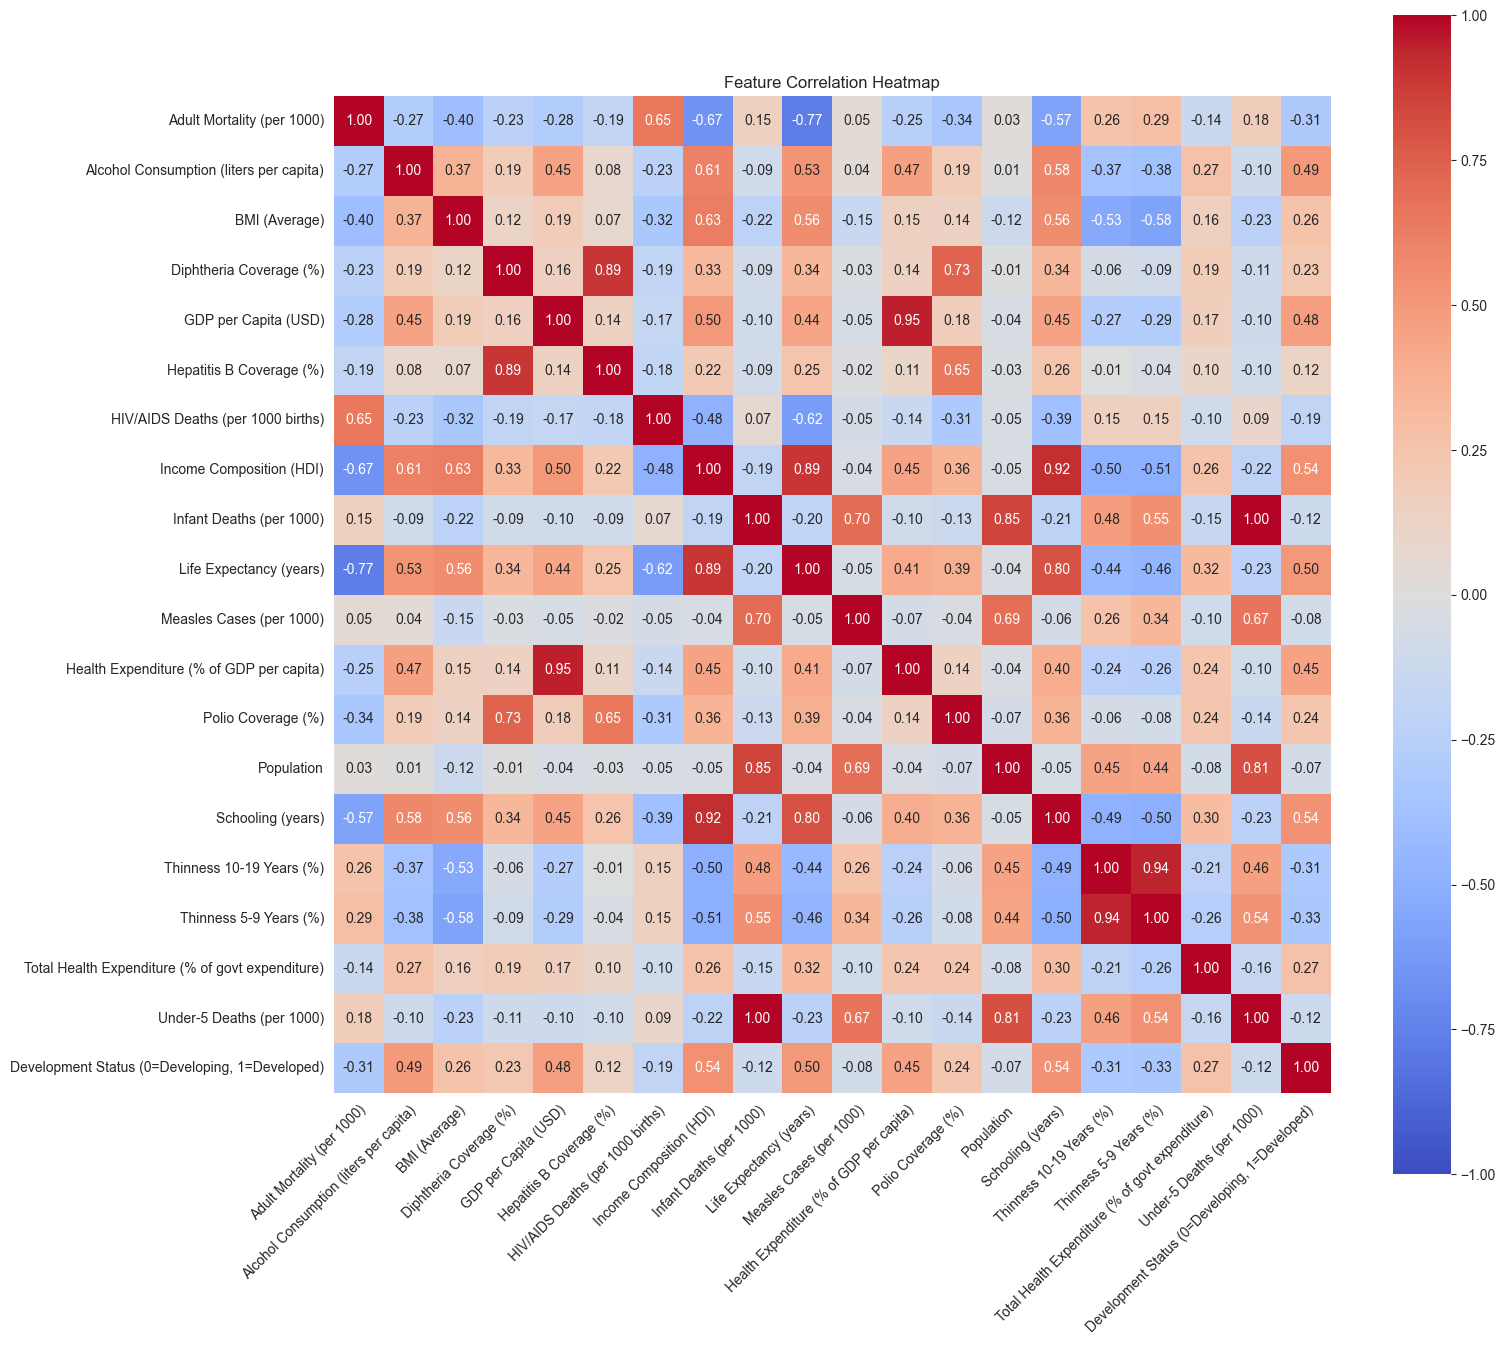

In [39]:
fig = plot_correlation_heatmap(corr_result, figsize=(16, 16))
plt.show()


## 2. Top Correlated Feature Pairs

Identifies the strongest positive and negative correlations for targeted analysis.

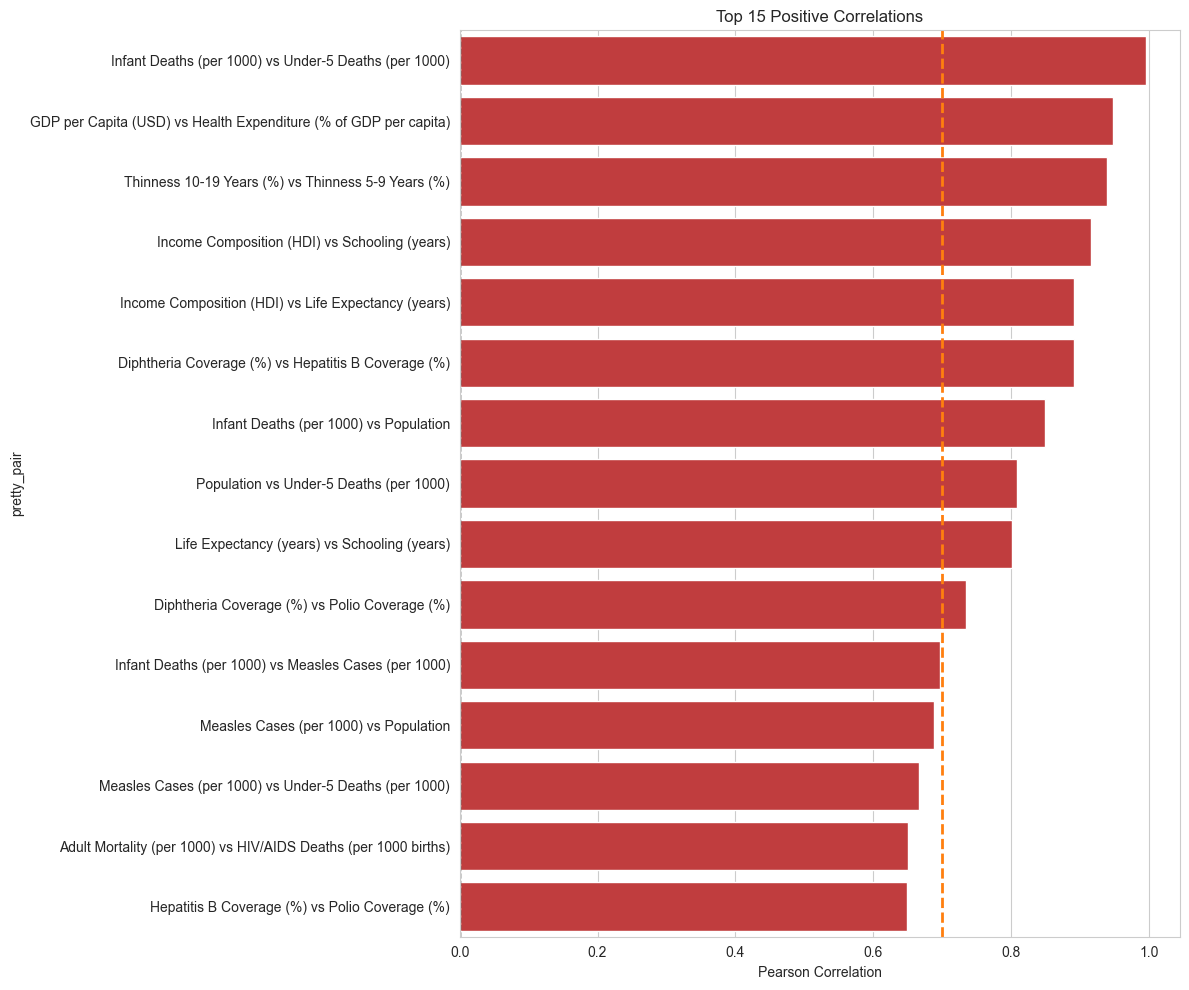

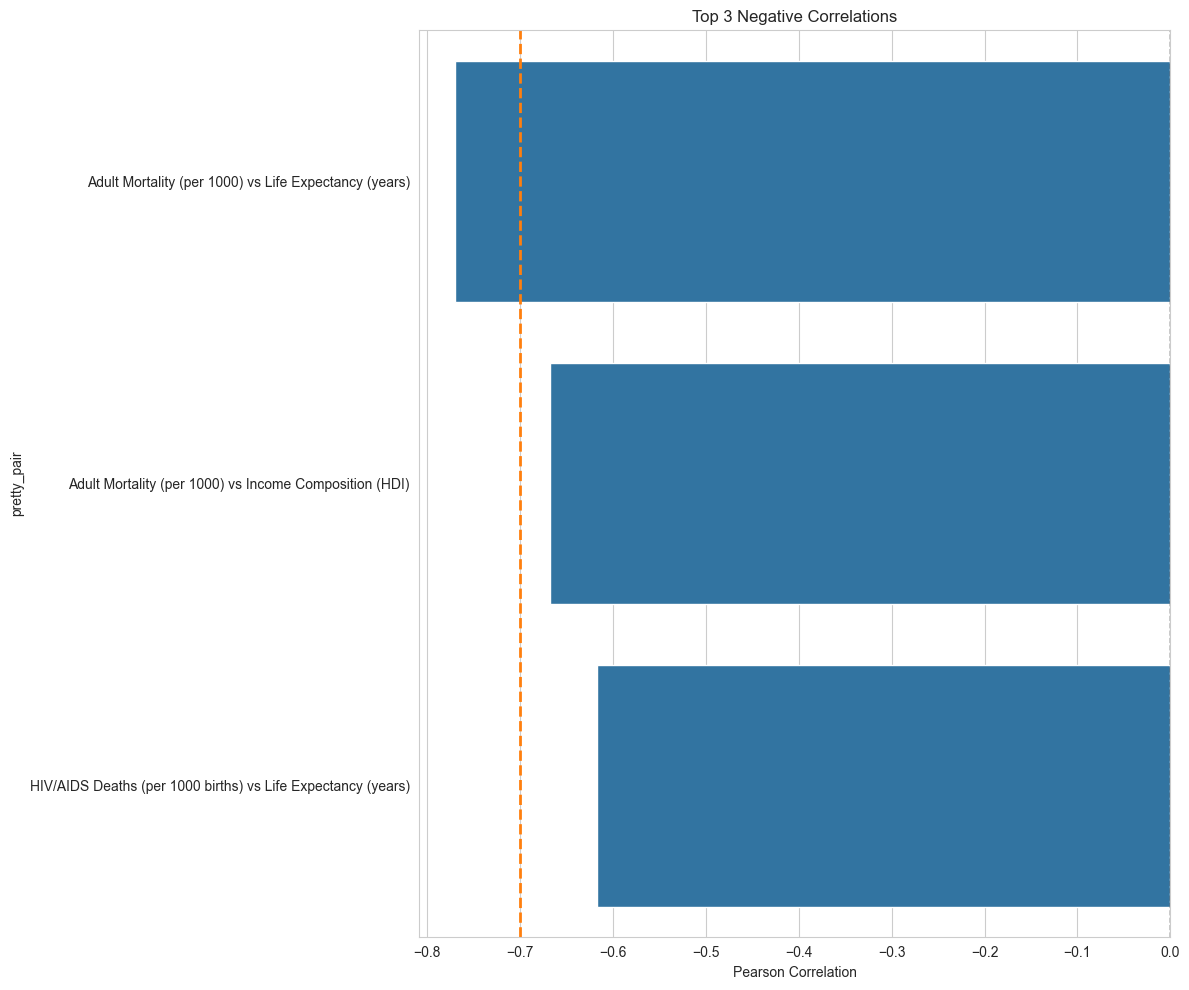

In [40]:
fig_pos, fig_neg = plot_top_correlated_pairs(corr_result, n=15, threshold=0.7)
plt.show()


## 3. Top Correlated Target Features

Identifies the strongest positive and negative correlations with the target variable.

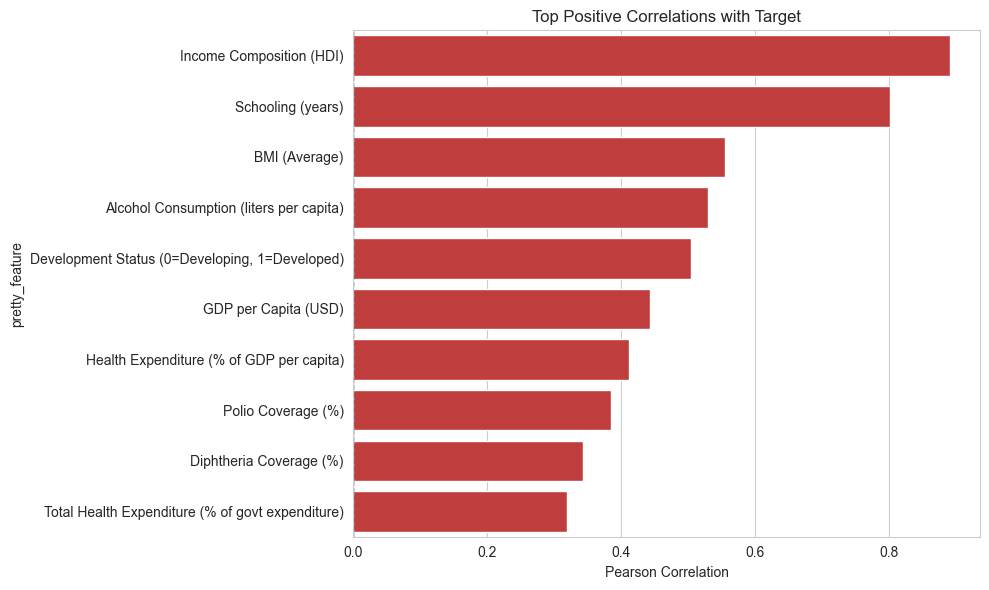

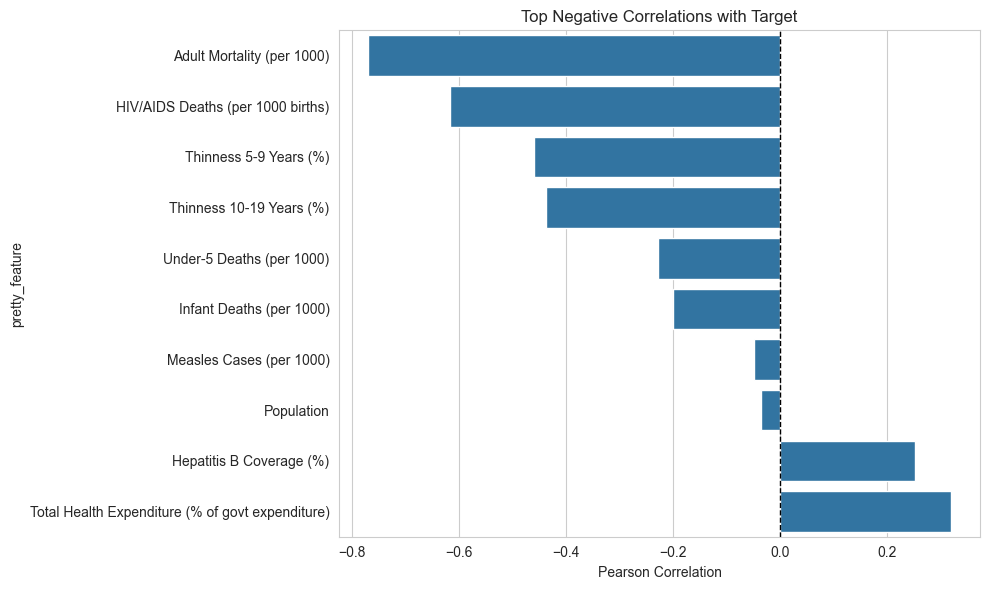

In [41]:
plot_target_correlations(result=corr_result)
plt.show()



## 3b. Effect of Transformations on Correlations

Compare the correlation structure before and after the default transforms (log/log1p and coverage inversion).
Delta = correlation(transformed) - correlation(raw); positive values mean the transform strengthened the linear relationship.


year  status  life_expectancy  adult_mortality  infant_deaths  \
country                                                                      
Afghanistan  2014       0             59.9         0.868181       1.471512   
Albania      2014       0             77.5        -2.530686      -1.111408   
Algeria      2014       0             75.4        -2.243824       0.801188   
Angola       2014       0             51.7         1.116741       1.499430   
Argentina    2014       0             76.2         0.043858       0.248134   
...           ...     ...              ...              ...            ...   
Uruguay      2014       0             76.8         0.035443      -1.111408   
Uzbekistan   2014       0             69.2         0.483833       0.641655   
Vanuatu      2014       0             71.7         0.169650      -1.111408   
Zambia       2014       0             61.1         1.014534       0.972121   
Zimbabwe     2014       0             59.2         1.180381       0.855026   

              alcohol  percentage_expenditure  hepatitis_b   measles  \
country                                                                
Afghanistan -0.748754               -0.410361     1.213565  1.026147   
Albania      0.355633                0.473724    -1.208615 -0.941088   
Algeria     -0.748754               -0.561474    -0.554050 -0.941088   
Angola       1.293135               -0.962188     1.163852  2.030888   
Argentina    1.194968                0.816905    -0.408479 -0.721174   
...               ...                     ...          ...       ...   
Uruguay      0.728671                0.513113    -0.554050 -0.941088   
Uzbekistan  -0.748754               -2.400730    -1.591512 -0.243975   
Vanuatu     -0.748754                0.612521     1.163852 -0.180308   
Zambia      -0.748754                0.081852     0.311239 -0.210547   
Zimbabwe     0.844018               -1.339363    -0.071657 -0.941088   

                  bmi  ...     polio  total_expenditure  diphtheria  hiv_aids  \
country                ...                                                      
Afghanistan -1.059125  ...  1.379213           0.821577    1.331756 -0.571266   
Albania      0.809728  ... -1.115737          -0.089841   -1.088540 -0.571266   
Algeria      0.867827  ... -0.466231           0.437196   -0.434484 -0.571266   
Angola      -0.860620  ...  1.131186          -1.108252    1.282081  1.312759   
Argentina    1.051807  ... -0.086294          -0.521774   -0.289026 -0.571266   
...               ...  ...       ...                ...         ...       ...   
Uruguay      1.109906  ... -0.466231           0.980085   -0.434484 -0.571266   
Uzbekistan   0.165797  ... -1.495674          -0.105692   -1.471138 -0.571266   
Vanuatu      0.582173  ...  1.212719          -0.359304    1.282081 -0.571266   
Zambia      -0.855778  ...  0.792902          -0.442520    0.430132  2.381419   
Zimbabwe    -0.444243  ... -0.086294           0.132069    0.047533  2.982638   

                  gdp  population  thinness_1_19_years  thinness_5_9_years  \
country                                                                      
Afghanistan -0.609920   -0.532322             2.054563            1.956932   
Albania      0.471021   -0.579813            -0.991140           -0.957499   
Algeria     -0.669998    1.275866             0.664444            0.557845   
Angola      -0.741760    0.264106             1.101253            0.995516   
Argentina    1.000519    1.311523            -1.127469           -1.224576   
...               ...         ...                  ...                 ...   
Uruguay      1.168647    0.354488            -0.808291           -0.898005   
Uzbekistan  -2.301502   -1.351000            -0.136013           -0.149403   
Vanuatu      0.269927   -1.491919            -0.808291           -0.898005   
Zambia      -0.049303    0.058478             0.724469            0.637747   
Zimbabwe    -1.451201    0.923741             0.643863            0.537

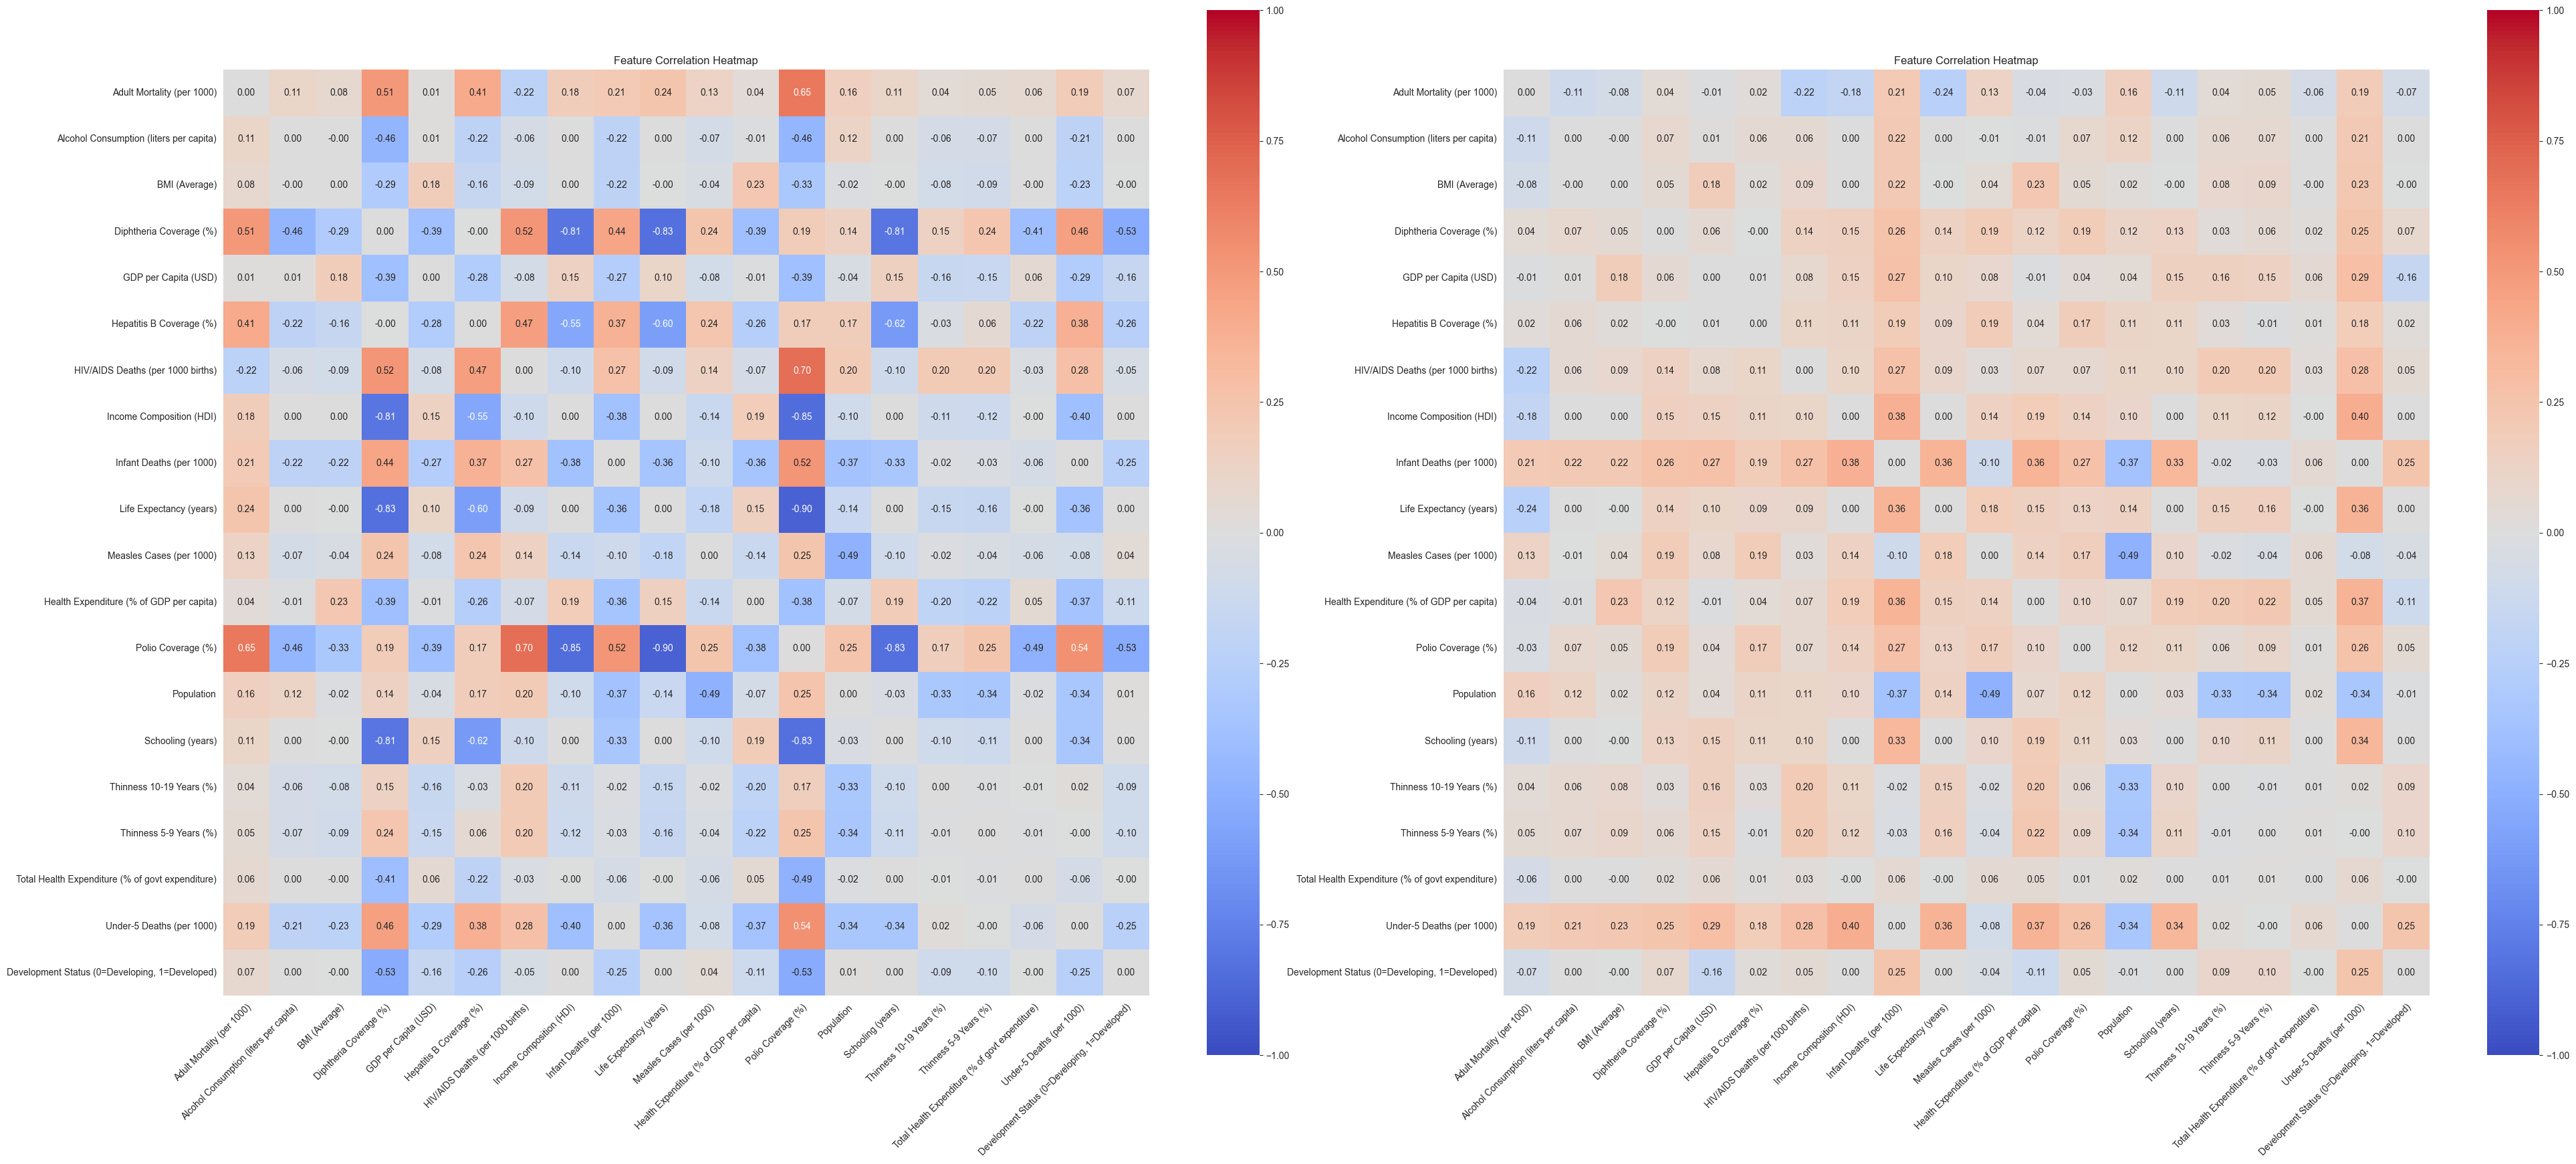

In [42]:
from ama_tlbx.analysis import CorrelationResult

tf_df = le_ds.tf_and_norm()
display(tf_df)

corr_result_tf = LifeExpectancyDataset(tf_df).make_correlation_analyzer().fit().result()

# Feature -> target deltas
base_tc = corr_result.target_correlations.set_index("feature")
tf_tc = corr_result_tf.target_correlations.set_index("feature")

delta_target = (
    tf_tc.rename(columns={"correlation": "corr_tf"})
    .join(base_tc.rename(columns={"correlation": "corr_raw"}))
    .assign(
        delta=lambda d: d.corr_tf - d.corr_raw,
        delta_abs=lambda d: d.corr_tf.abs() - d.corr_raw.abs(),
        pretty=lambda d: d.index.map(le_ds.get_pretty_name),
    )
    .assign(abs_delta=lambda d: d.delta.abs())
    .sort_values("abs_delta", ascending=False)
)


delta_result = CorrelationResult(
    matrix=corr_result_tf.matrix - corr_result.matrix,
    pretty_by_col=corr_result.pretty_by_col,
    feature_pairs=pd.DataFrame(),
)
delta_result_abs = CorrelationResult(
    matrix=corr_result_tf.matrix.abs() - corr_result.matrix.abs(),
    pretty_by_col=corr_result.pretty_by_col,
    feature_pairs=pd.DataFrame(),
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))
delta_corr = delta_result.matrix
plot_correlation_heatmap(delta_result, ax=ax1)
plot_correlation_heatmap(delta_result_abs, ax=ax2)
plt.show()


pretty  corr_raw  \
feature                                                                      
polio                                         Polio Coverage (%)  0.385156   
diphtheria                               Diphtheria Coverage (%)  0.342464   
hepatitis_b                             Hepatitis B Coverage (%)  0.252098   
under_five_deaths                      Under-5 Deaths (per 1000) -0.228570   
infant_deaths                           Infant Deaths (per 1000) -0.200942   
adult_mortality                       Adult Mortality (per 1000) -0.770069   
measles                                 Measles Cases (per 1000) -0.048756   
thinness_5_9_years                        Thinness 5-9 Years (%) -0.460959   
percentage_expenditure  Health Expenditure (% of GDP per capita)  0.412596   
thinness_1_19_years                     Thinness 10-19 Years (%) -0.436944   
population                                            Population -0.035990   
gdp                                         GDP per Capita (USD)  0.443771   

                         corr_tf     delta  delta_abs  
feature                                                
polio                  -0.517337 -0.902493   0.132182  
diphtheria             -0.486564 -0.829027   0.144100  
hepatitis_b            -0.346761 -0.598858   0.094663  
under_five_deaths      -0.589766 -0.361196   0.361196  
infant_deaths          -0.560274 -0.359332   0.359332  
adult_mortality        -0.525102  0.244967  -0.244967  
measles                -0.231340 -0.182584   0.182584  
thinness_5_9_years     -0.622333 -0.161374   0.161374  
percentage_expenditure  0.564462  0.151866   0.151866  
thinness_1_19_years    -0.585650 -0.148706   0.148706  
population             -0.177962 -0.141972   0.141972  
gdp                     0.546855  0.103084   0.103084

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/2560381508.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/2560381508.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


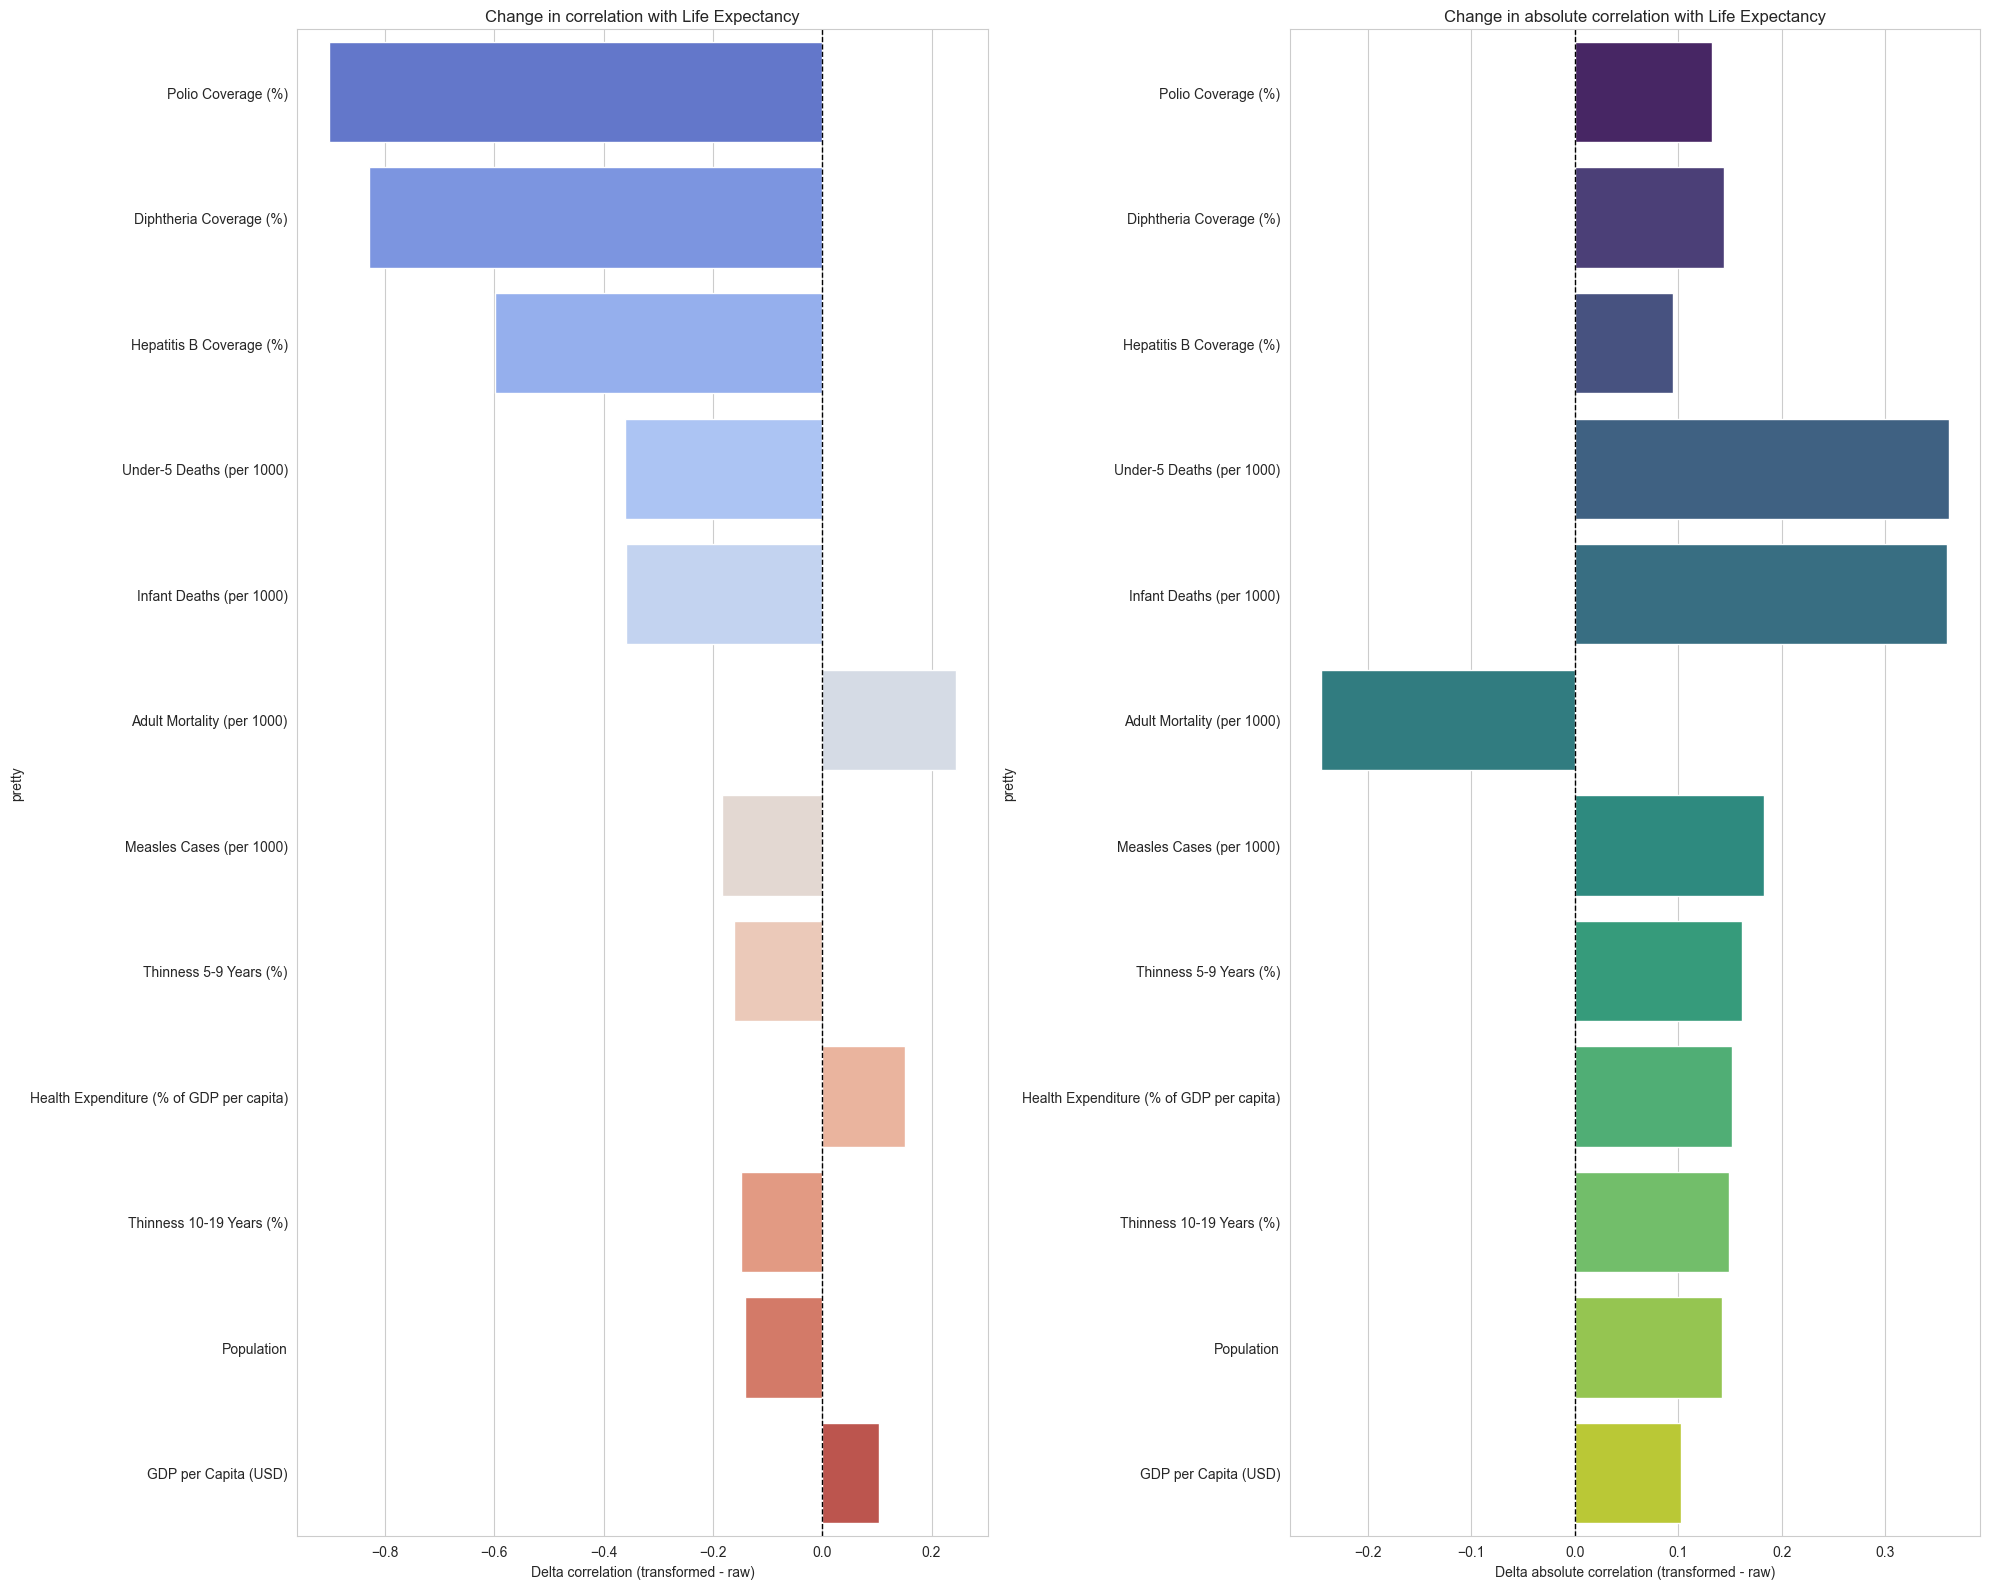

In [43]:
delta_target_top = delta_target[
    ["pretty", "corr_raw", "corr_tf", "delta", "delta_abs"]
].head(12)
display(delta_target_top)

# Visualize change in feature-target correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))
sns.barplot(
    data=delta_target.reset_index().head(12),
    x="delta",
    y="pretty",
    palette="coolwarm",
    ax=ax1,
)
ax1.axvline(0, color="black", linestyle="--", linewidth=1)
ax1.set_title("Change in correlation with Life Expectancy")
ax1.set_xlabel("Delta correlation (transformed - raw)")
plt.tight_layout()

sns.barplot(
    data=delta_target.reset_index().head(12),
    x="delta_abs",
    y="pretty",
    palette="viridis",
    ax=ax2,
)
ax2.axvline(0, color="black", linestyle="--", linewidth=1)
ax2.set_title("Change in absolute correlation with Life Expectancy")
ax2.set_xlabel("Delta absolute correlation (transformed - raw)")
plt.tight_layout()
plt.show()


['adult_mortality', 'alcohol', 'bmi', 'diphtheria', 'gdp', 'hepatitis_b', 'hiv_aids', 'implied_health_exp', 'income_composition_of_resources', 'infant_deaths', 'measles', 'percentage_expenditure', 'polio', 'population', 'schooling', 'thinness_1_19_years', 'thinness_5_9_years', 'total_expenditure', 'under_five_deaths', <LifeExpectancyColumn.STATUS: 'status'>]
Skip alcohol: 'NoneType' object has no attribute '__name__'
Skip bmi: 'NoneType' object has no attribute '__name__'


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

Skip implied_health_exp: "['implied_health_exp'] not in index"
Skip income_composition_of_resources: 'NoneType' object has no attribute '__name__'


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/opt/homebrew/Caskroom/miniconda/base/envs/ama/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/opt/homebrew/Caskroom/miniconda/base/envs/ama/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_

Skip schooling: 'NoneType' object has no attribute '__name__'


/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1169522413.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Skip total_expenditure: 'NoneType' object has no attribute '__name__'
Skip status: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


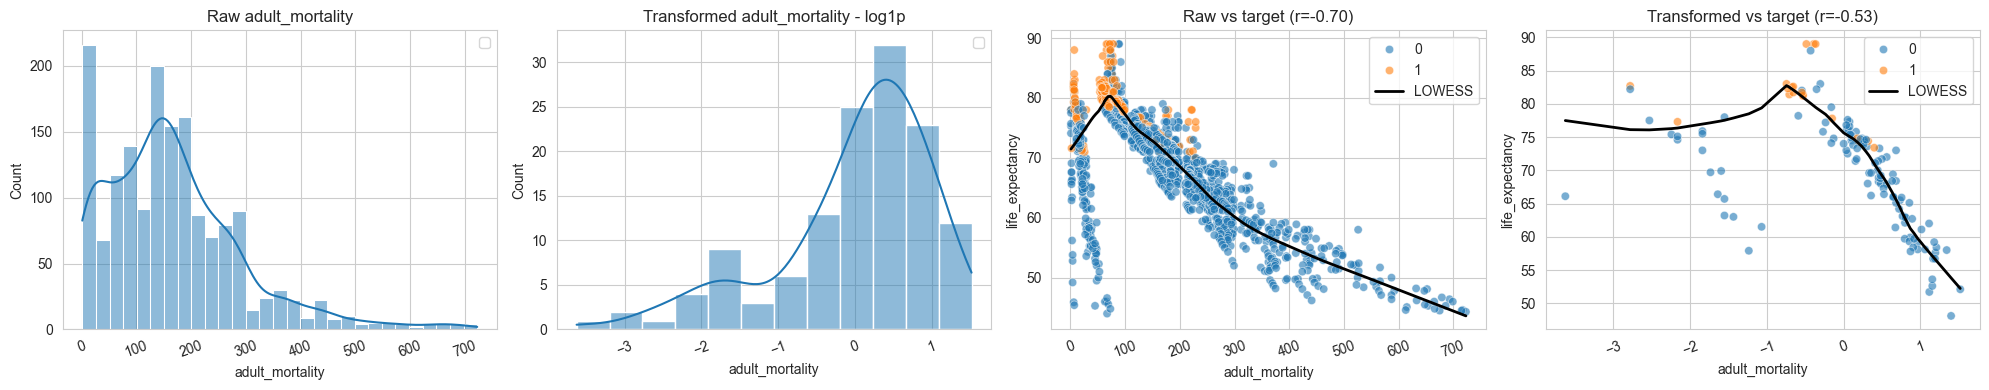

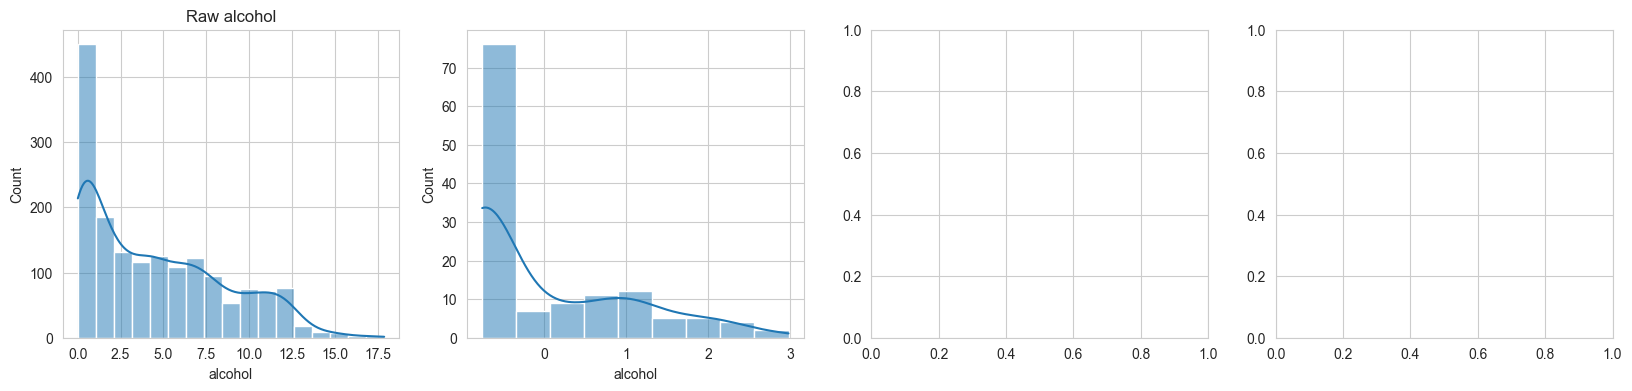

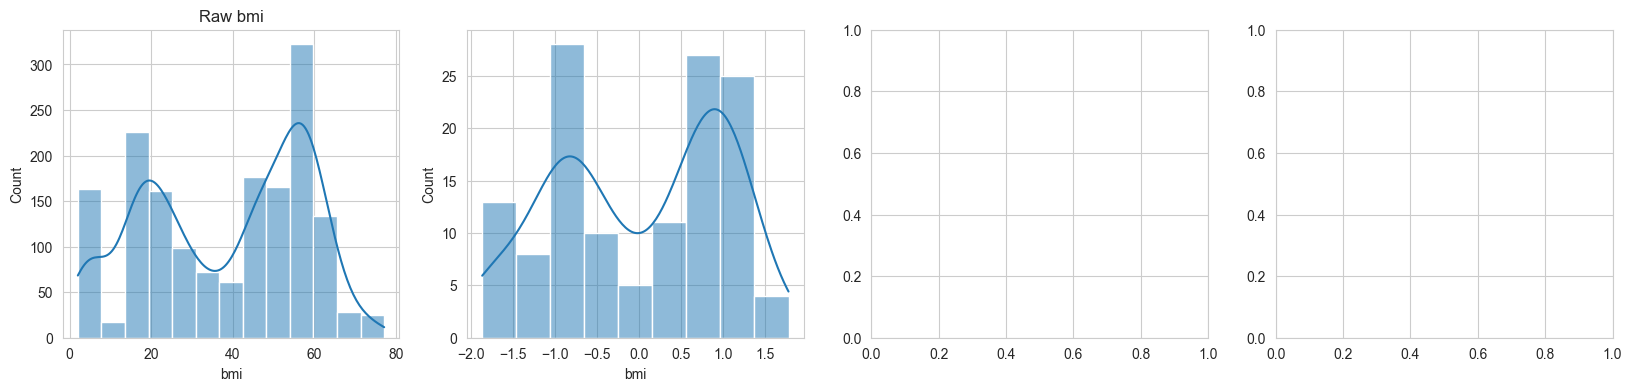

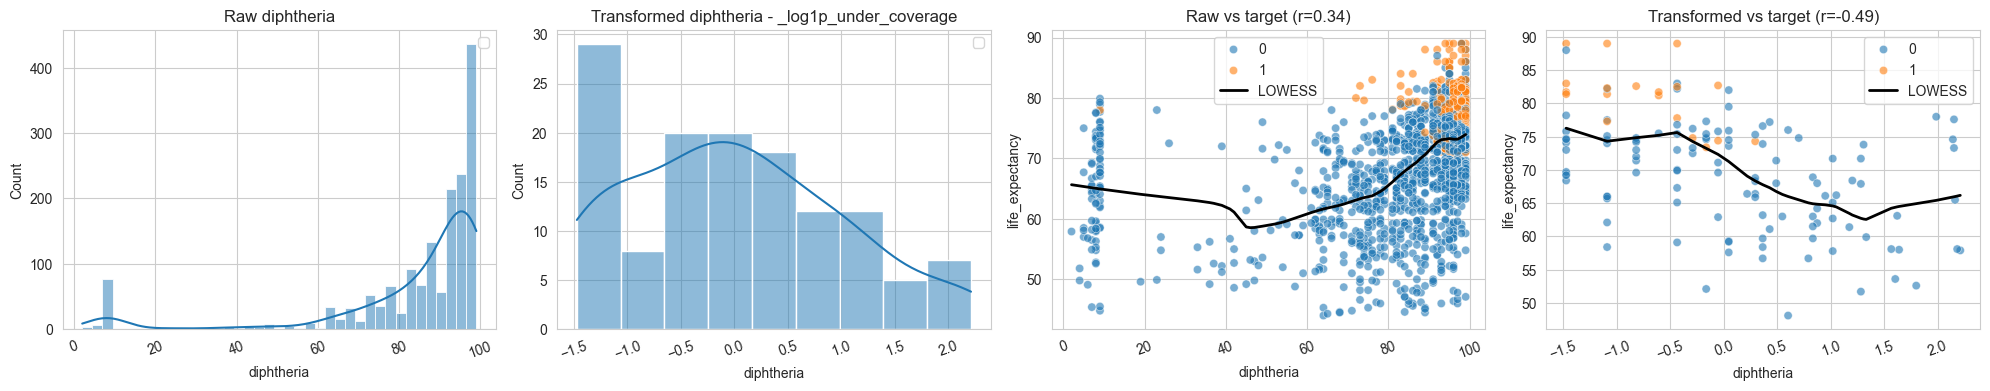

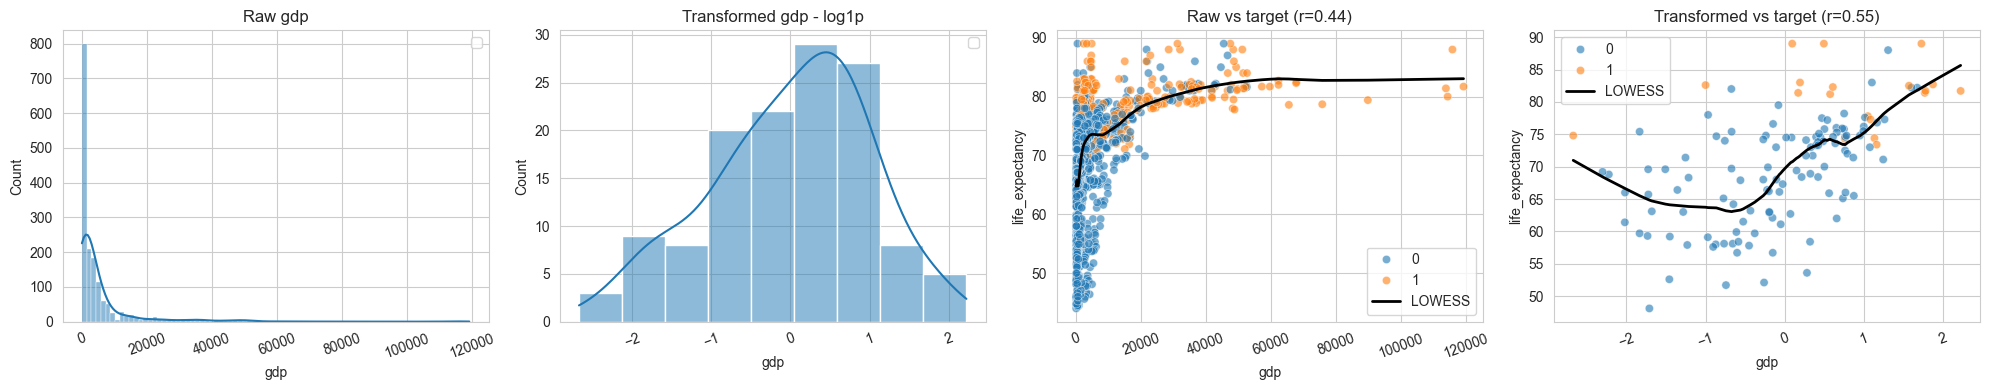

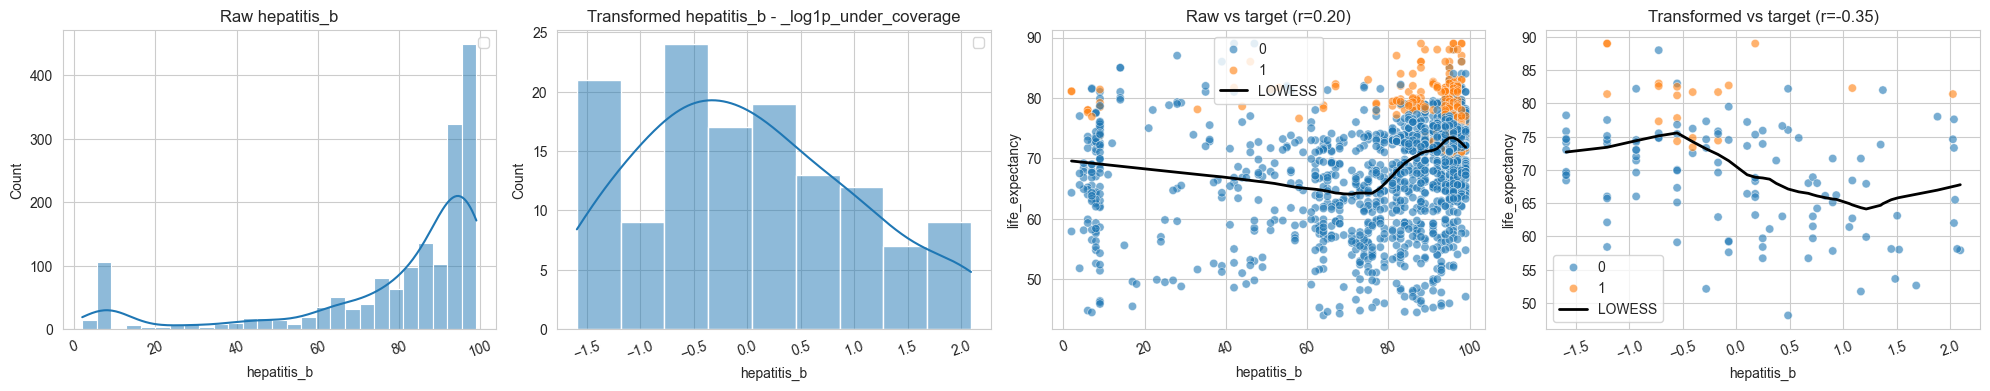

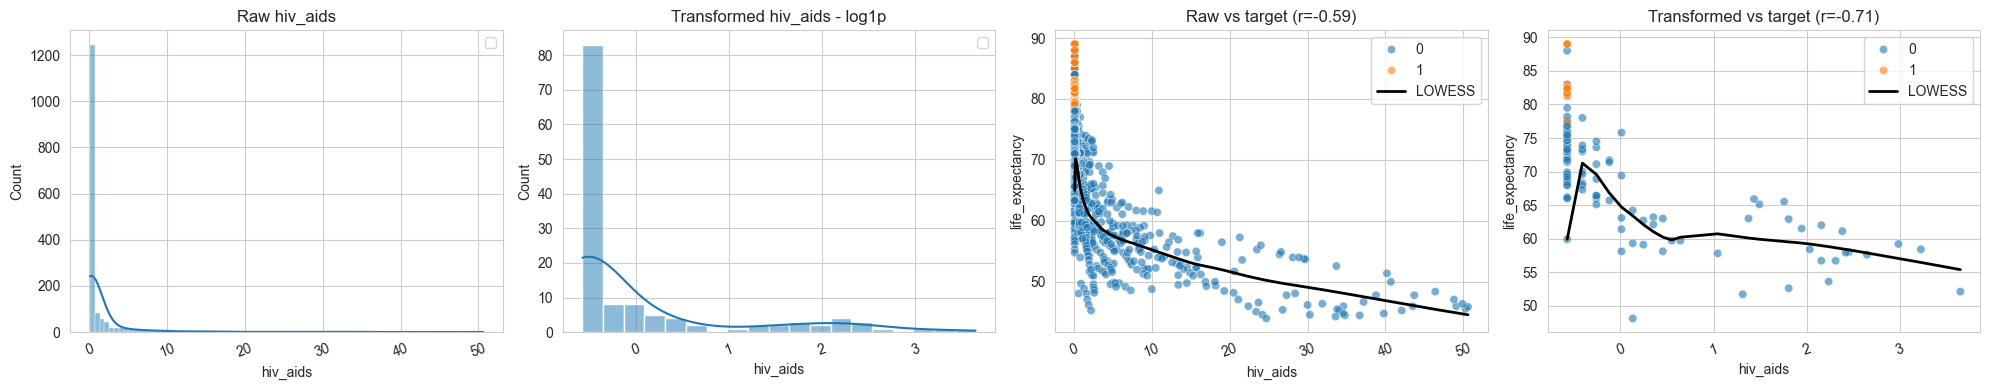

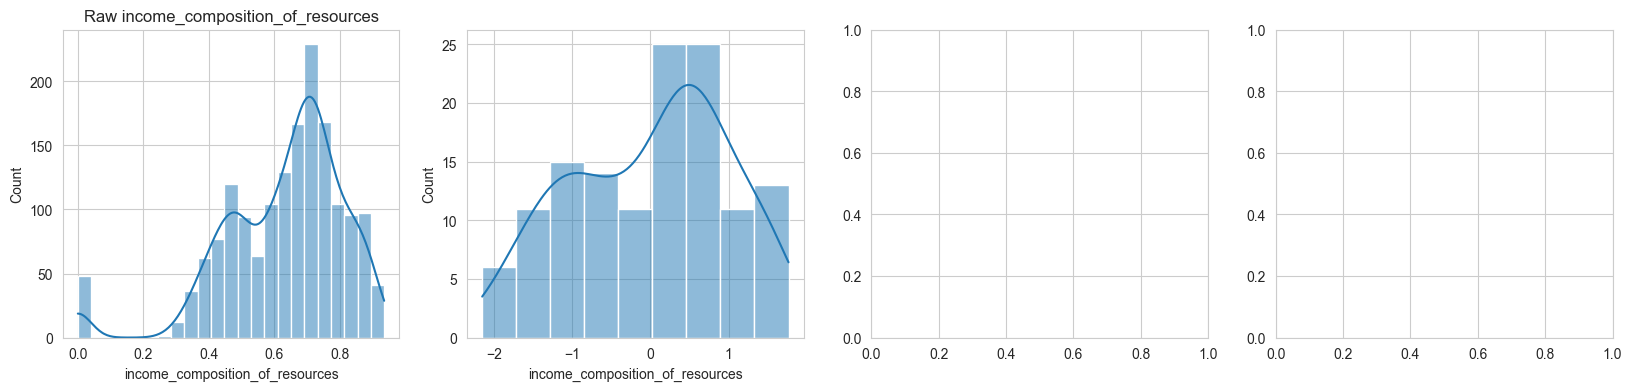

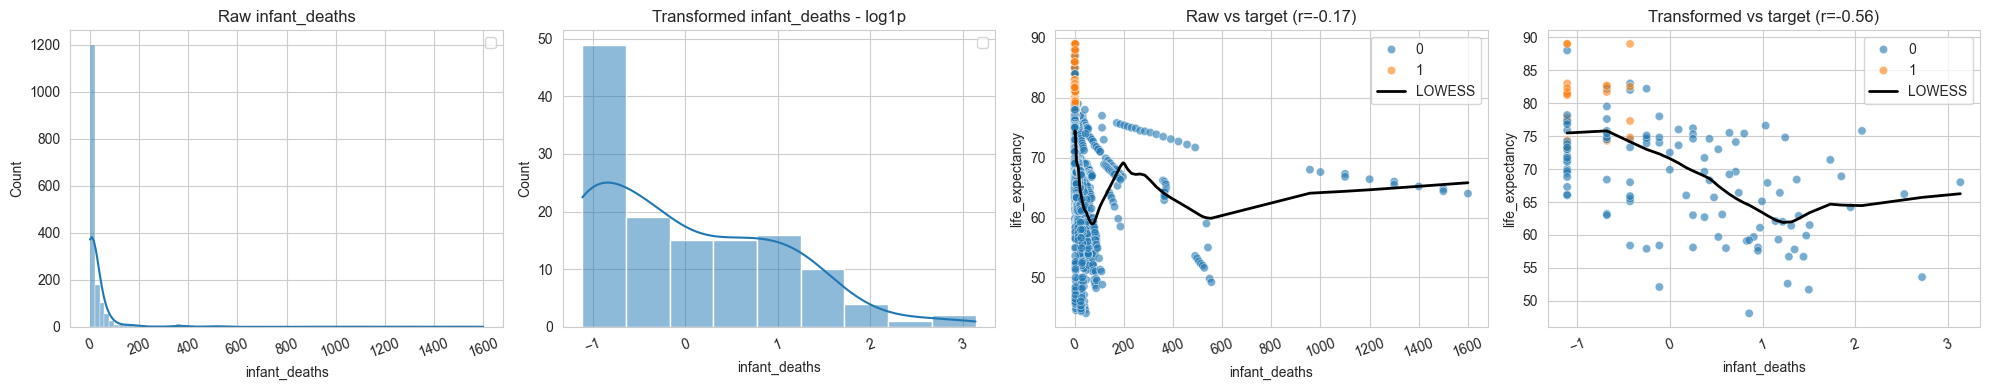

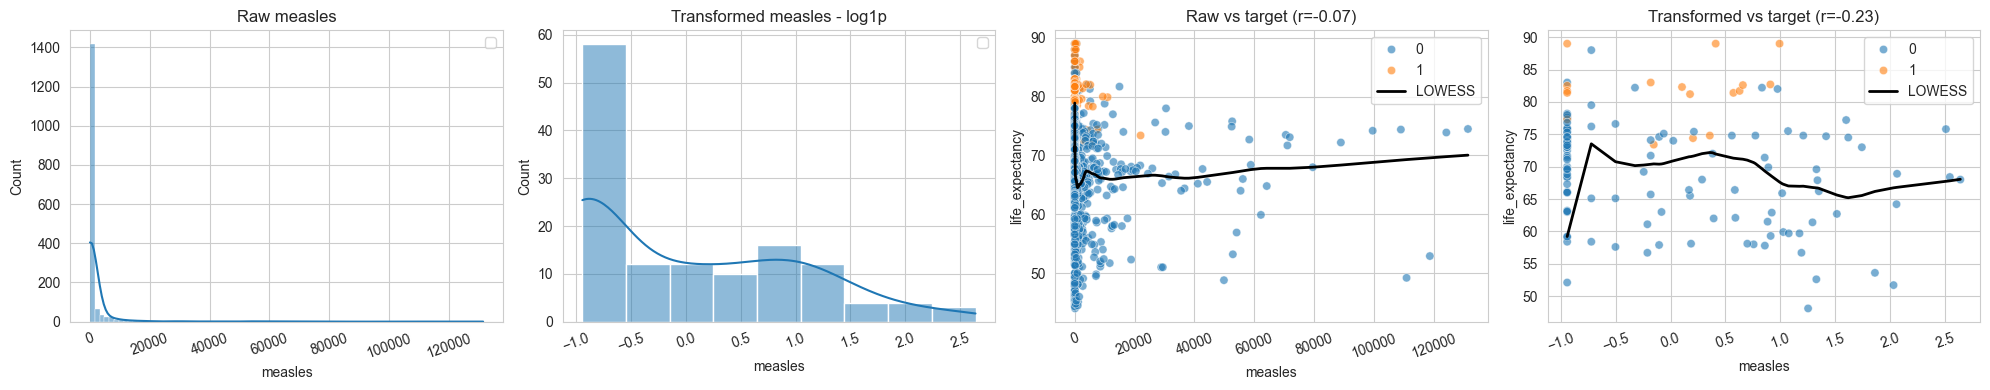

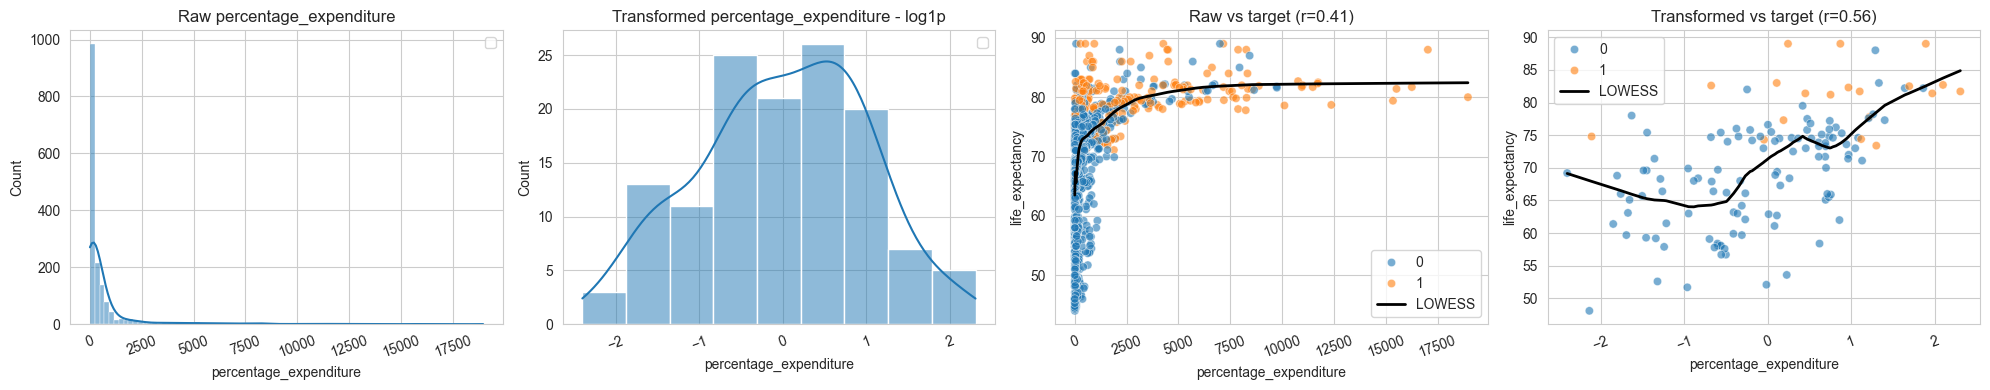

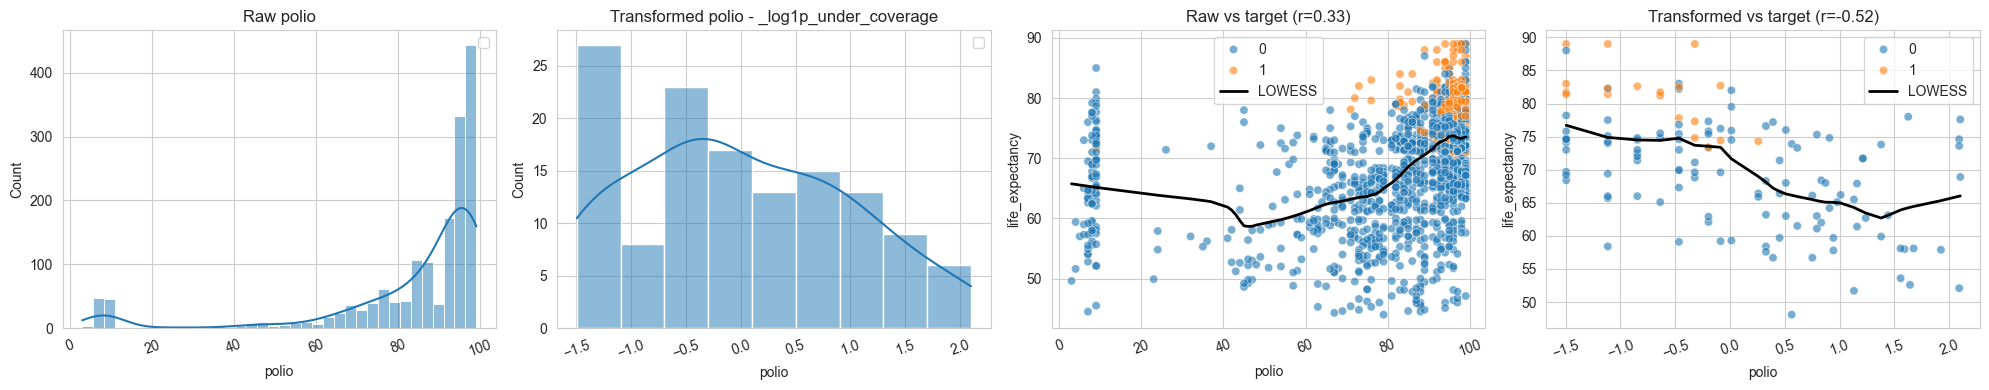

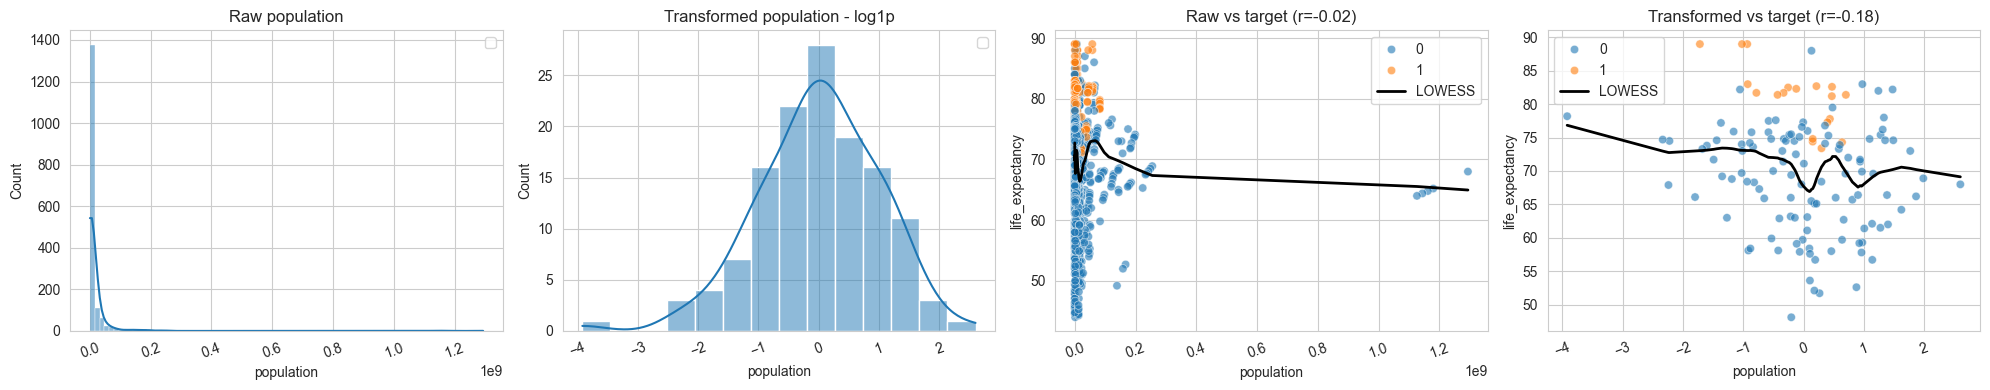

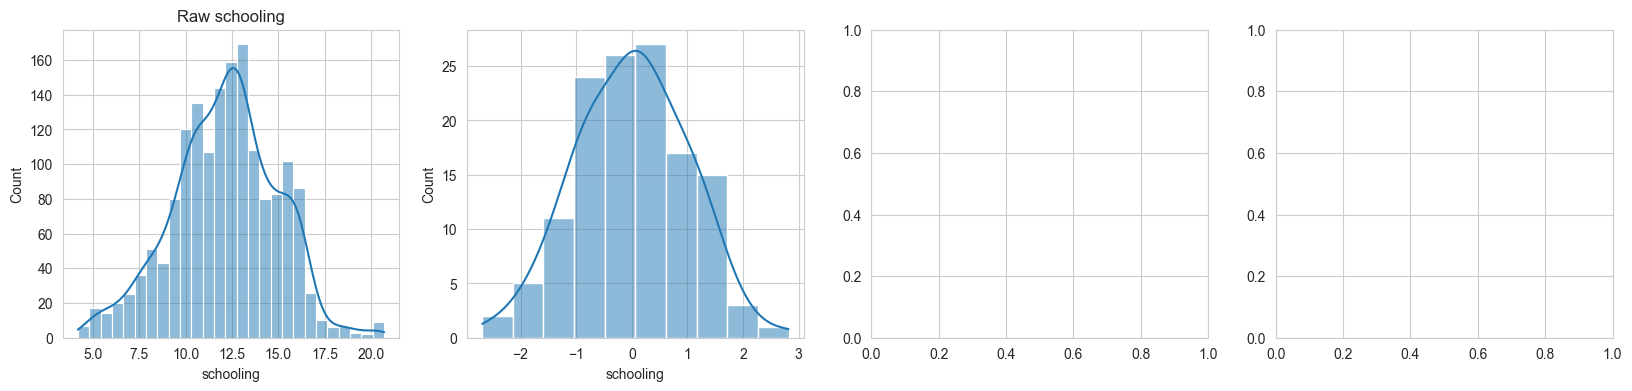

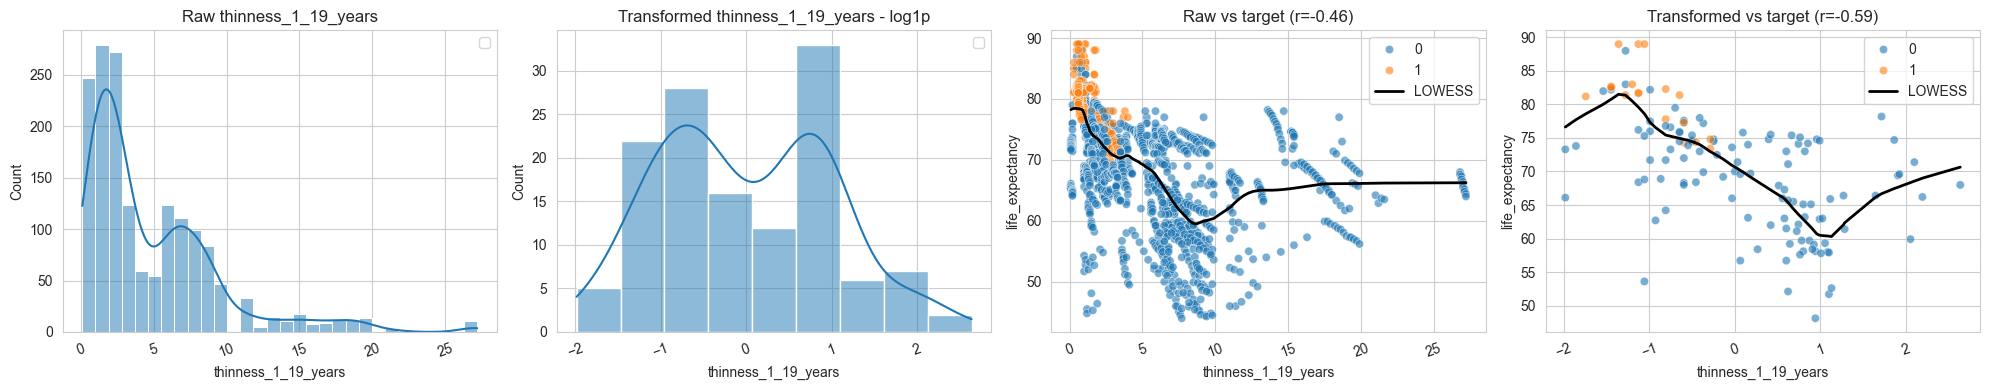

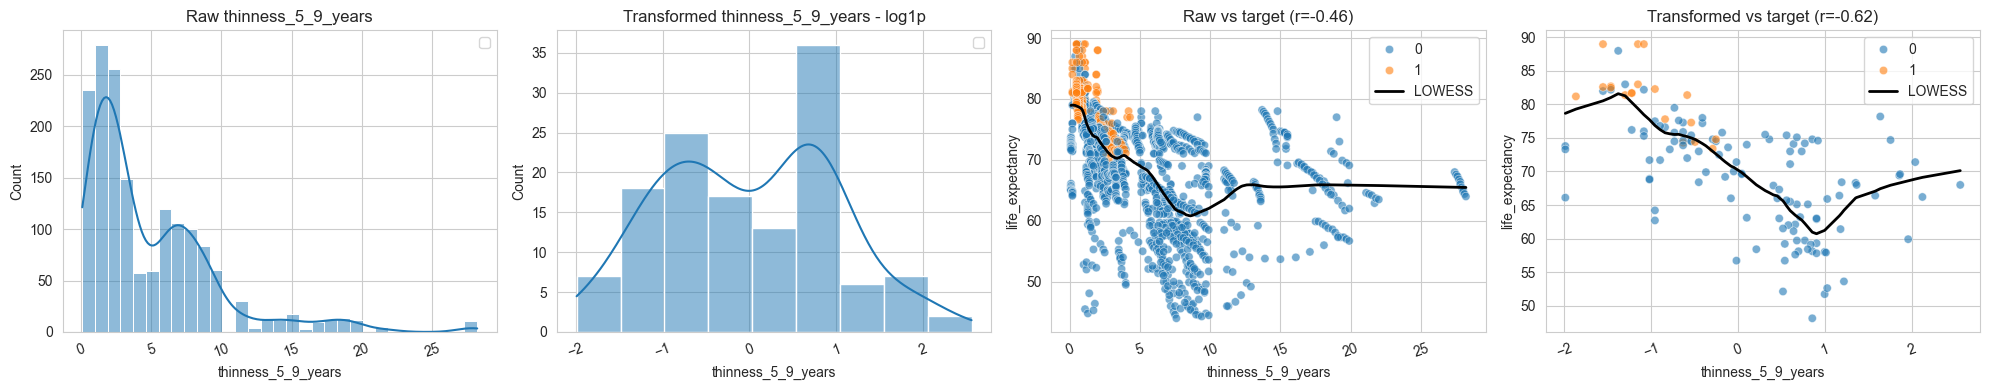

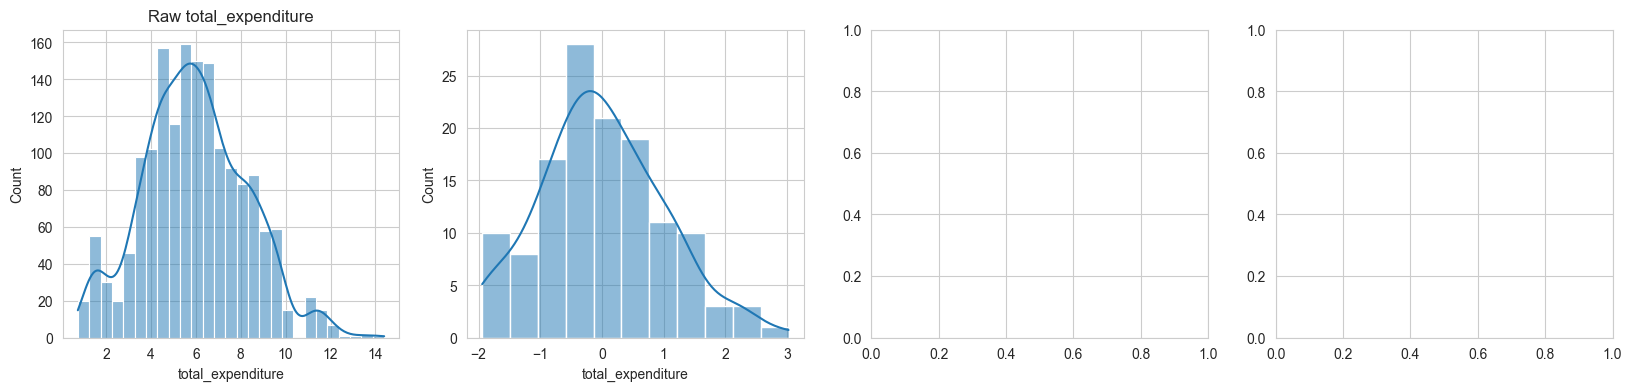

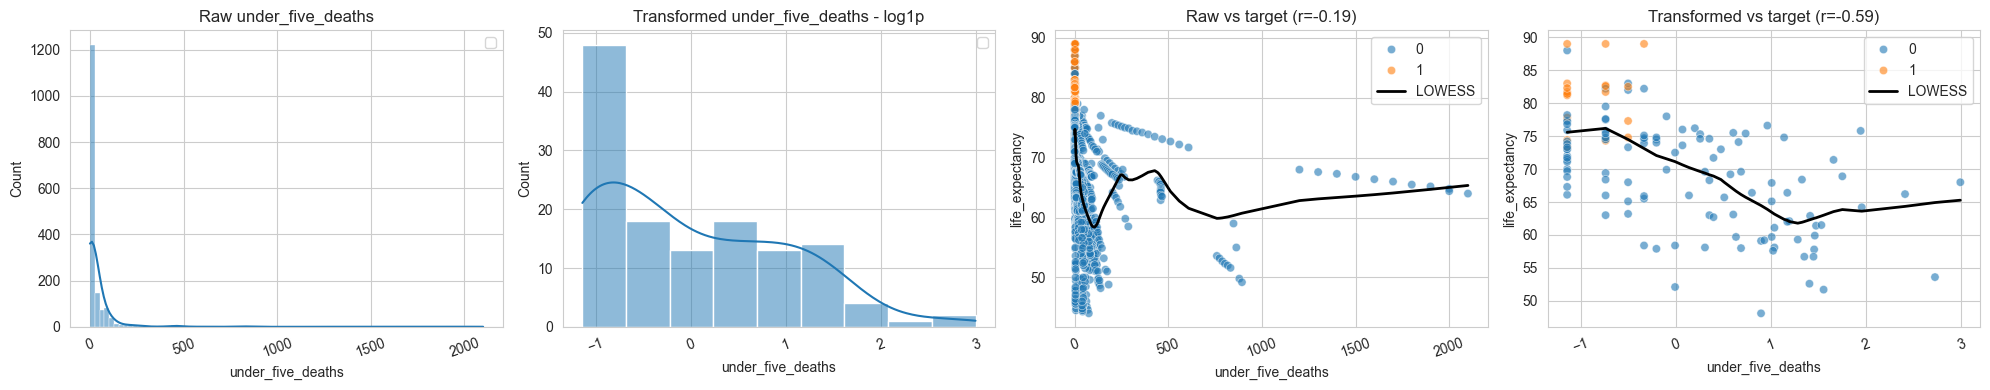

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def diagnose_transform(
    col: str,
    target: str = LECol.LIFE_EXPECTANCY,
    hue: str | None = LECol.STATUS,
    lowess_frac: float = 0.3,
):
    """Compare raw vs transformed distribution and target correlation for one feature.

    - Hue is applied to the scatter points only.
    - A single LOWESS line is drawn per panel (global fit), not per hue.
    """
    col = str(col)
    target = str(target)
    hue = str(hue) if hue else None

    raw = le_ds.df[[col, target] + ([hue] if hue else [])].dropna()
    tf = tf_df[[col, target] + ([hue] if hue else [])].dropna()

    corr_raw = raw[col].corr(raw[target])
    corr_tf = tf[col].corr(tf[target])

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    sns.histplot(raw[col], kde=True, ax=axes[0])
    axes[0].set_title(f"Raw {col}")

    sns.histplot(tf[col], kde=True, ax=axes[1])
    tf = LECol(col).metadata().transform
    tf_name = ""
    if tf is not None:
        tf_name = LECol(col).metadata().transform.__name__
    axes[1].set_title(f"Transformed {col} - {LECol(col).metadata().transform.__name__}")

    # Scatter with hue; one global LOWESS per panel
    sns.scatterplot(data=raw, x=col, y=target, hue=hue, alpha=0.6, ax=axes[2])
    if len(raw) >= 8:
        smooth = lowess(raw[target], raw[col], frac=lowess_frac, return_sorted=True)
        axes[2].plot(
            smooth[:, 0], smooth[:, 1], color="black", linewidth=2, label="LOWESS"
        )
    axes[2].set_title(f"Raw vs target (r={corr_raw:.2f})")

    sns.scatterplot(data=tf, x=col, y=target, hue=hue, alpha=0.6, ax=axes[3])
    if len(tf) >= 8:
        smooth_tf = lowess(tf[target], tf[col], frac=lowess_frac, return_sorted=True)
        axes[3].plot(
            smooth_tf[:, 0], smooth_tf[:, 1], color="black", linewidth=2, label="LOWESS"
        )
    axes[3].set_title(f"Transformed vs target (r={corr_tf:.2f})")

    for ax in axes:
        ax.tick_params(axis="x", rotation=20)
        if hue:
            ax.legend()

    plt.tight_layout()
    return corr_raw, corr_tf


# Batch run example
auto_cols = le_ds.feature_columns()
print(auto_cols)
for col in auto_cols:
    try:
        diagnose_transform(col)
    except Exception as e:
        print(f"Skip {col}: {e}")


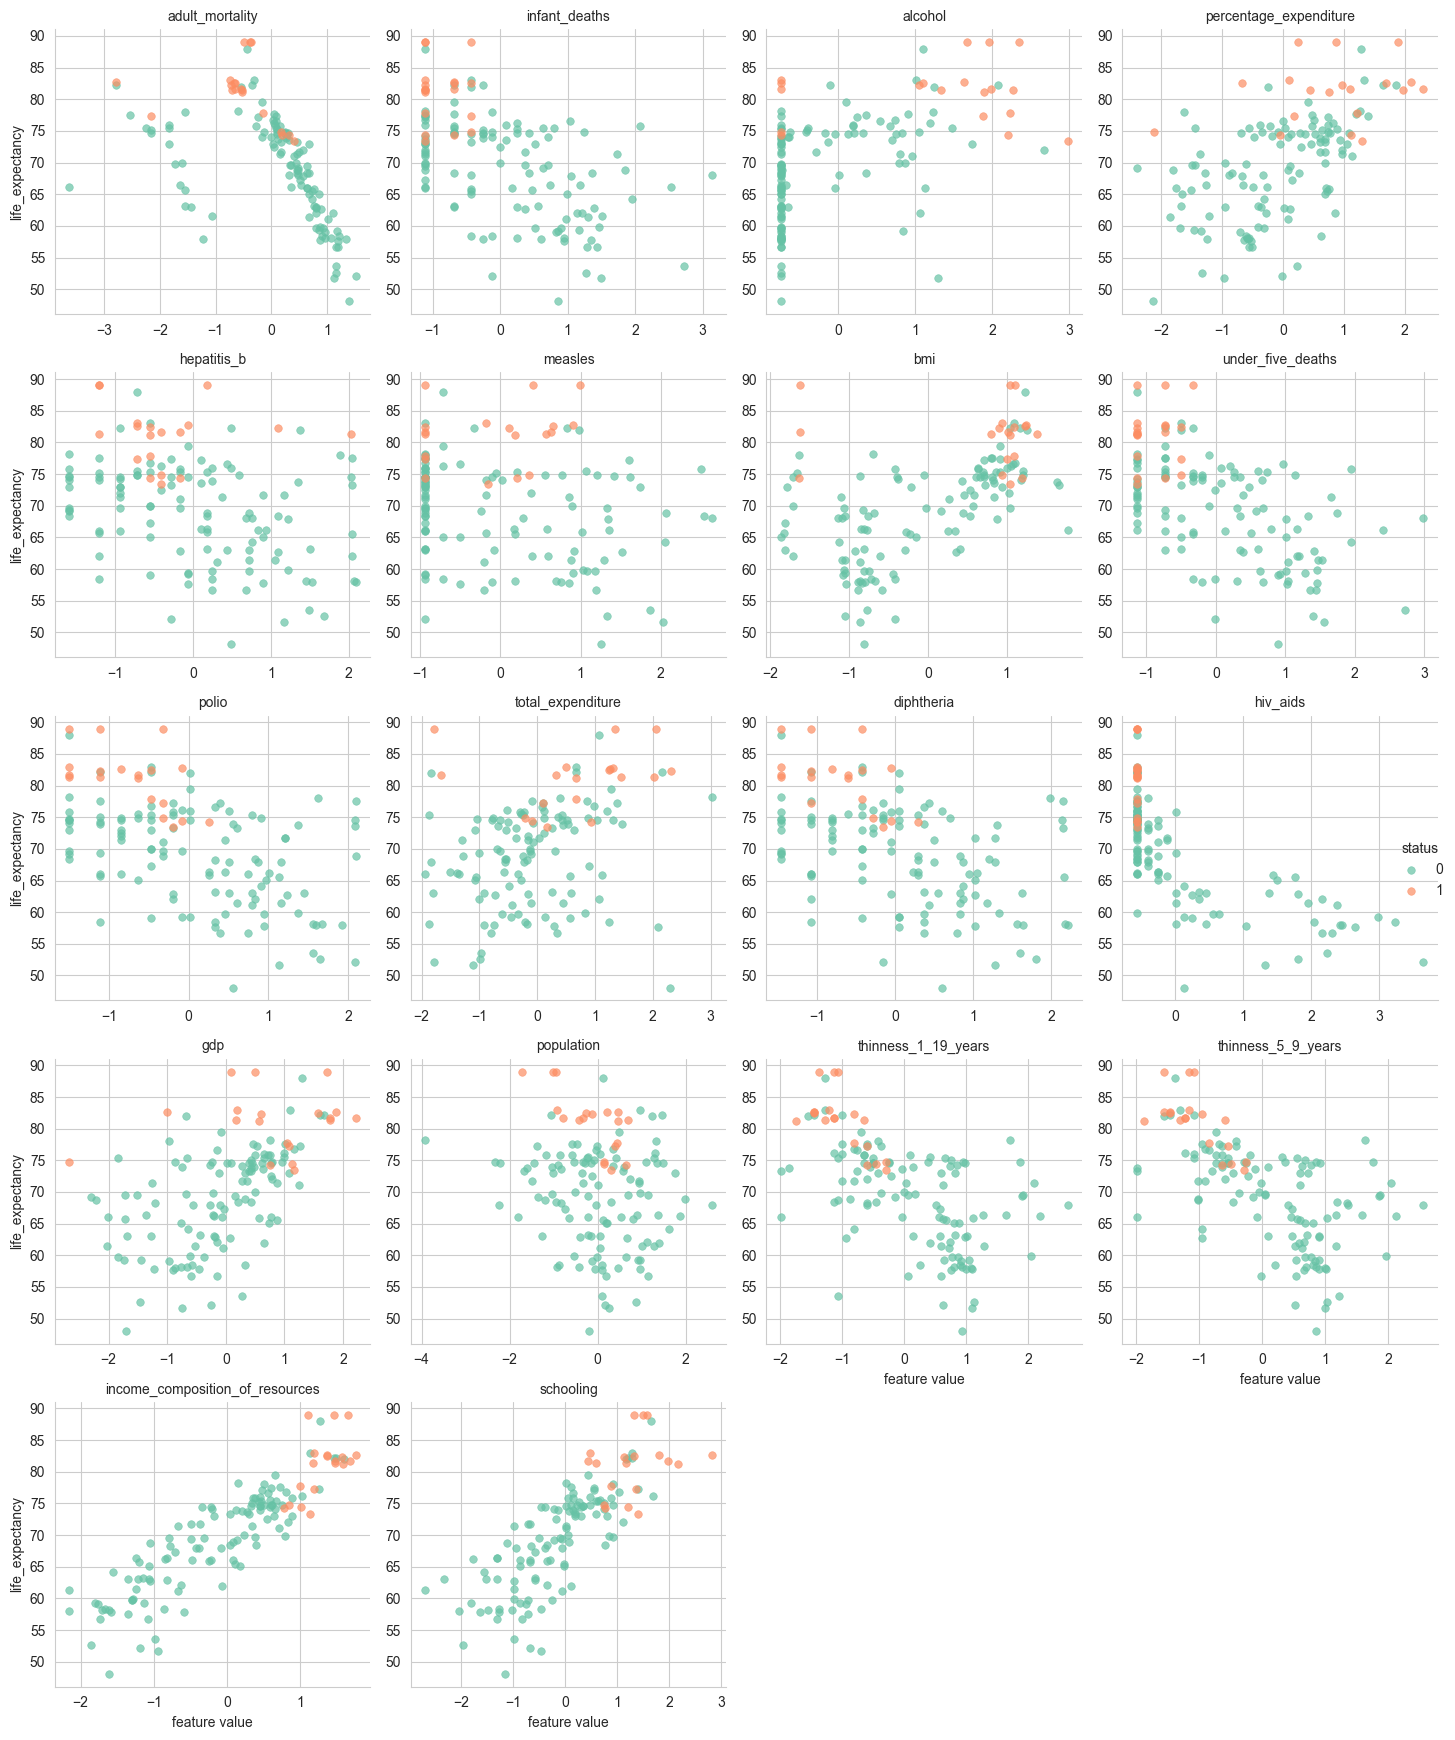

In [45]:
def plot_all_predictors_vs_target(
    df: pd.DataFrame,
    features: list[str],
    target: str,
    hue: str | None = None,
    wrap: int = 4,
):
    target = str(target)
    hue = str(hue) if hue else None

    # remove target/hue from features to avoid duplicates
    drop_set = {target} | ({hue} if hue else set())
    features = [str(f) for f in features if str(f) not in drop_set]

    id_vars = [target] + ([hue] if hue else [])
    long = df[features + id_vars].melt(
        id_vars=id_vars, value_vars=features, var_name="feature", value_name="value"
    )

    height = max(2.5, min(4.0, 14 / wrap))
    g = sns.FacetGrid(
        long,
        col="feature",
        col_wrap=wrap,
        sharex=False,
        sharey=False,
        height=height,
        hue=hue,
        palette="Set2" if hue else None,
    )
    g.map_dataframe(
        sns.scatterplot, x="value", y=target, alpha=0.7, s=30, edgecolor=None
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("feature value", target)
    if hue:
        g.add_legend()
    plt.tight_layout()
    return g


# Example:
feature_cols = tf_df.columns.tolist()
feature_cols.remove(LECol.YEAR)
plot_all_predictors_vs_target(
    tf_df,
    feature_cols,
    target=LECol.LIFE_EXPECTANCY.value,
    hue=LECol.STATUS.value,
    wrap=4,
)


## 4. Automatic Feature Grouping Suggestion

Uses correlation structure to suggest feature groups for PCA dimensionality reduction.

In [46]:
from devtools import pprint


corr_mat = (
    LifeExpectancyDataset.from_csv()
    .make_correlation_analyzer(include_target=False)
    .get_correlation_matrix()
)
tresh = 0.8
suggested_groups, summary_df = suggest_groups_from_correlation(
    corr_mat, threshold=tresh, return_summary=True
)
pprint(suggested_groups)
summary_df


[
    FeatureGroup(
        name='Group_3',
        features=[
            'thinness_1_19_years',
            'thinness_5_9_years',
        ],
    ),
    FeatureGroup(
        name='Group_4',
        features=[
            'income_composition_of_resources',
            'schooling',
        ],
    ),
    FeatureGroup(
        name='Group_6',
        features=[
            'gdp',
            'percentage_expenditure',
        ],
    ),
    FeatureGroup(
        name='Group_10',
        features=[
            'infant_deaths',
            'population',
            'under_five_deaths',
        ],
    ),
]


group  size                                      features  \
0  Group_10     3  infant_deaths, population, under_five_deaths   
1   Group_3     2       thinness_1_19_years, thinness_5_9_years   
2   Group_4     2    income_composition_of_resources, schooling   
3   Group_6     2                   gdp, percentage_expenditure   

   mean_abs_corr  min_abs_corr  
0       0.909977      0.857915  
1       0.851031      0.851031  
2       0.844781      0.844781  
3       0.961792      0.961792

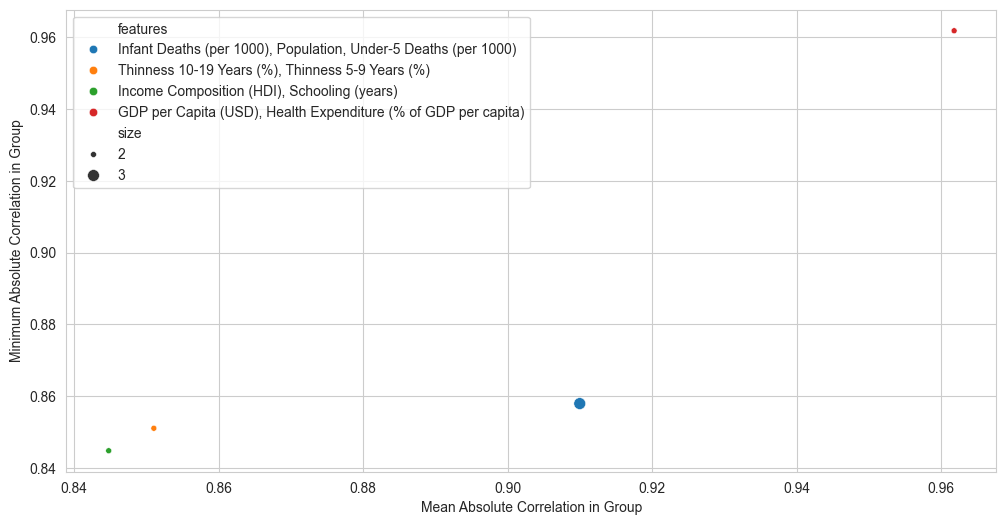

In [47]:
sns.scatterplot(
    data=summary_df.assign(feature_list=summary_df.features.str.split(",")).assign(
        pretty_features=lambda d: d.feature_list.apply(
            lambda lst: [le_ds.get_pretty_name(f.strip()) for f in lst]
        ),
        features=lambda d: d.pretty_features.apply(", ".join),
    ),
    x="mean_abs_corr",
    y="min_abs_corr",
    hue="features",
    size="size",
)
plt.xlabel("Mean Absolute Correlation in Group")
plt.ylabel("Minimum Absolute Correlation in Group")
plt.show()


[
    FeatureGroup(
        name='Group_1',
        features=[
            'diphtheria',
            'hepatitis_b',
            'polio',
        ],
    ),
    FeatureGroup(
        name='Group_2',
        features=[
            'infant_deaths',
            'under_five_deaths',
        ],
    ),
    FeatureGroup(
        name='Group_7',
        features=[
            'thinness_1_19_years',
            'thinness_5_9_years',
        ],
    ),
    FeatureGroup(
        name='Group_9',
        features=[
            'gdp',
            'percentage_expenditure',
        ],
    ),
    FeatureGroup(
        name='Group_10',
        features=[
            'income_composition_of_resources',
            'schooling',
        ],
    ),
]


group  size                                    features  mean_abs_corr  \
0   Group_1     3              diphtheria, hepatitis_b, polio       0.879280   
1  Group_10     2  income_composition_of_resources, schooling       0.915950   
2   Group_2     2            infant_deaths, under_five_deaths       0.995749   
3   Group_7     2     thinness_1_19_years, thinness_5_9_years       0.926959   
4   Group_9     2                 gdp, percentage_expenditure       0.939020   

   min_abs_corr  
0      0.821530  
1      0.915950  
2      0.995749  
3      0.926959  
4      0.939020

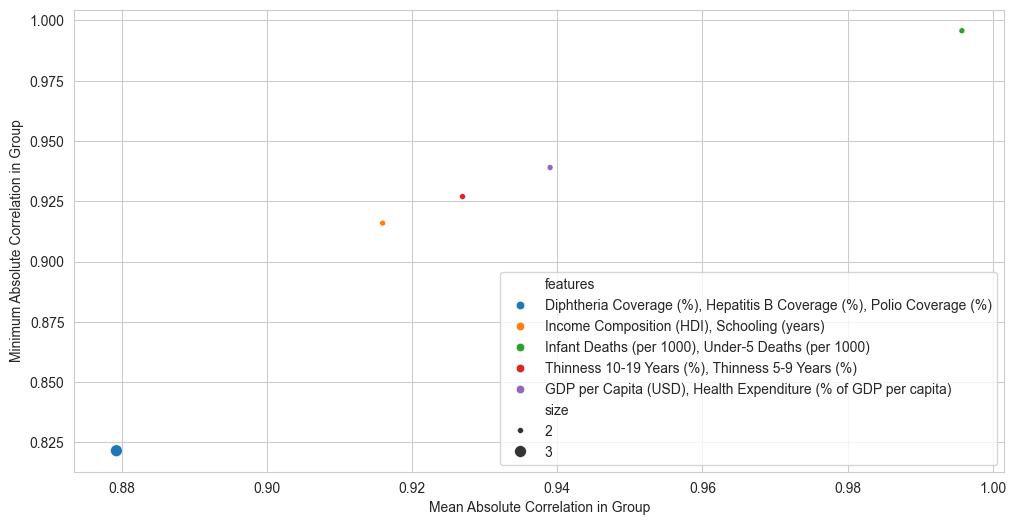

In [ ]:
corr_mat = (
    LifeExpectancyDataset(df=tf_df)
    .make_correlation_analyzer(include_target=False)
    .get_correlation_matrix()
)
tresh = 0.8
suggested_groups, summary_df = suggest_groups_from_correlation(
    corr_mat, threshold=tresh, return_summary=True
)
pprint(suggested_groups)
display(summary_df)

sns.scatterplot(
    data=summary_df.assign(feature_list=summary_df.features.str.split(",")).assign(
        pretty_features=lambda d: d.feature_list.apply(
            lambda lst: [le_ds.get_pretty_name(f.strip()) for f in lst]
        ),
        features=lambda d: d.pretty_features.apply(", ".join),
    ),
    x="mean_abs_corr",
    y="min_abs_corr",
    hue="features",
    size="size",
)
plt.xlabel("Mean Absolute Correlation in Group")
plt.ylabel("Minimum Absolute Correlation in Group")
plt.show()


## 5. Inspection of Mechanic Correlations

Correlation Matrix:
                          gdp  percentage_expenditure  total_expenditure  \
gdp                     1.000                   0.959              0.180   
percentage_expenditure  0.959                   1.000              0.184   
total_expenditure       0.180                   0.184              1.000   
implied_health_exp      0.856                   0.887              0.112   

                        implied_health_exp  
gdp                                  0.856  
percentage_expenditure               0.887  
total_expenditure                    0.112  
implied_health_exp                   1.000  

Correlation with Life Expectancy:
None


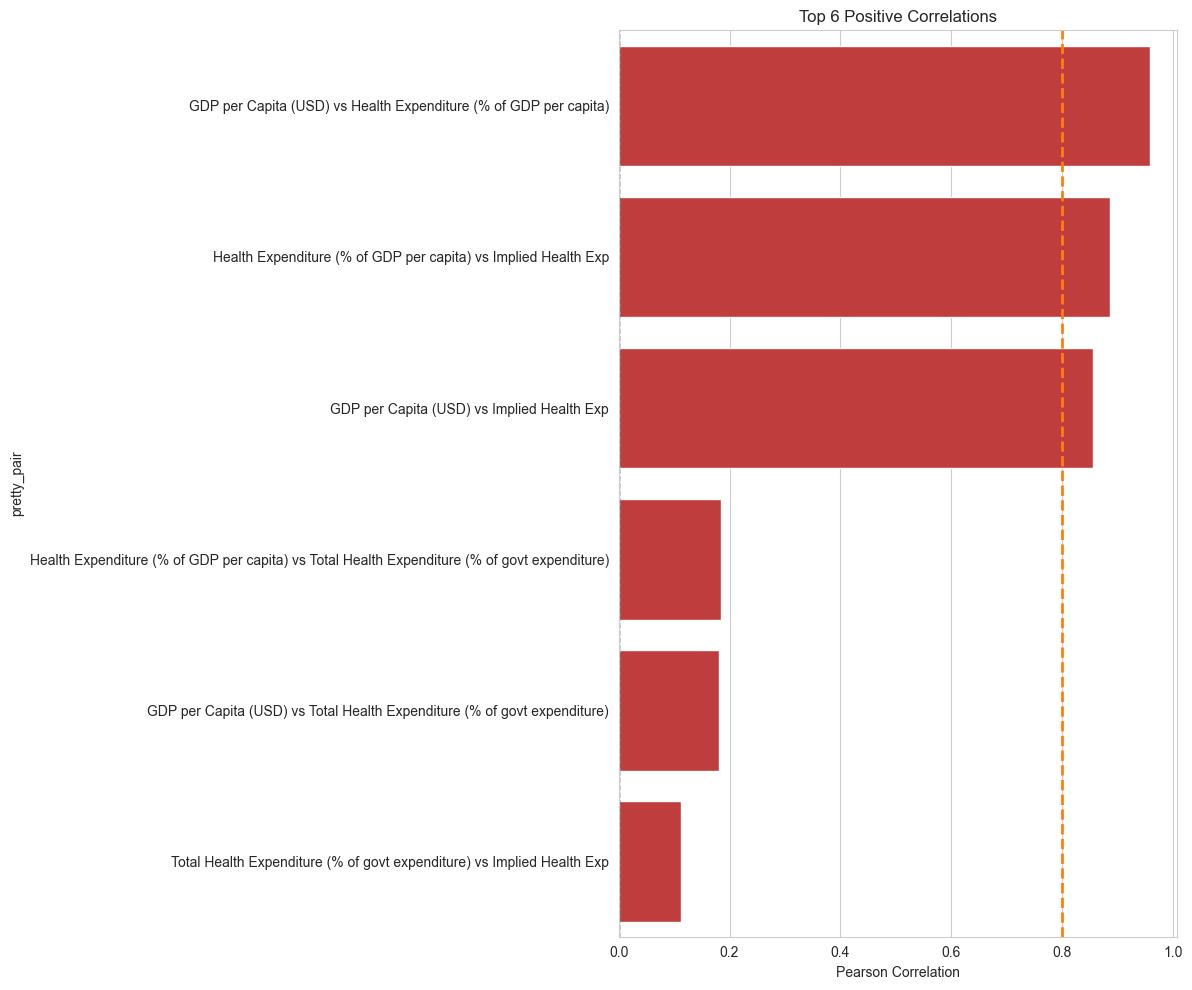

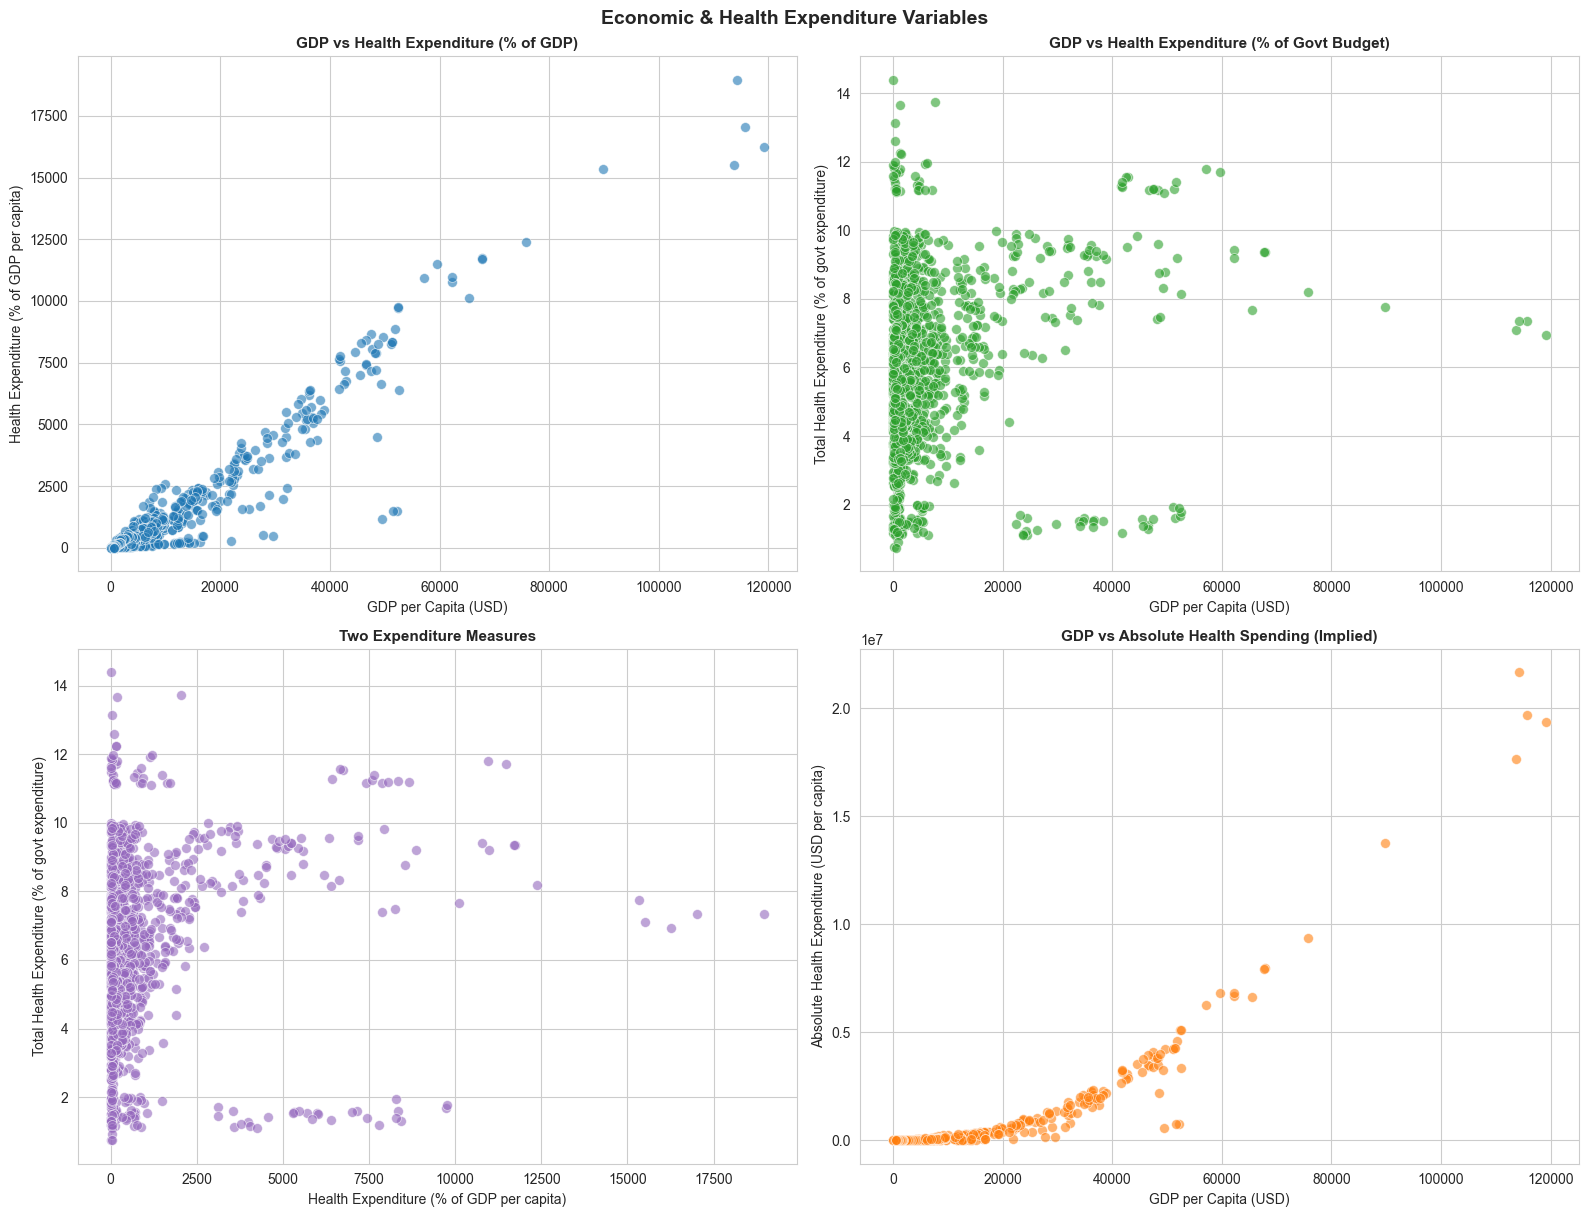

In [53]:
le_ds = (
    LifeExpectancyDataset.from_csv(aggregate_by_country=False)
    .df.assign(
        implied_health_exp=lambda df: df[LECol.GDP]
        * df[LECol.PERCENTAGE_EXPENDITURE]
        / (100)
    )
    .pipe(LifeExpectancyDataset)
)


# Analyze the three economic/expenditure variables
econ_vars = [
    LECol.GDP,
    LECol.PERCENTAGE_EXPENDITURE,
    LECol.TOTAL_EXPENDITURE,
    "implied_health_exp",
]

# Correlation analysis
corr_result = (
    le_ds.make_correlation_analyzer(
        standardized=True, include_target=True, columns=econ_vars
    )
    .fit()
    .result()
)

print("Correlation Matrix:")
print(corr_result.matrix.round(3))
print("\nCorrelation with Life Expectancy:")
print(corr_result.target_correlations)

fig_pos, fig_neg = plot_top_correlated_pairs(corr_result)
plt.close(fig_neg)
del fig_neg
plt.show(fig_pos)


# Create pretty names mapping for plotting
plot_cols = {
    LECol.GDP: le_ds.get_pretty_name(LECol.GDP),
    LECol.PERCENTAGE_EXPENDITURE: le_ds.get_pretty_name(LECol.PERCENTAGE_EXPENDITURE),
    LECol.TOTAL_EXPENDITURE: le_ds.get_pretty_name(LECol.TOTAL_EXPENDITURE),
    "implied_health_exp": "Absolute Health Expenditure (USD per capita)",
    LECol.TARGET: le_ds.get_pretty_name(LECol.TARGET),
}

# Rename columns for plotting
df_plot = le_ds.df.rename(columns=plot_cols)

# Set seaborn style
sns.set_style("whitegrid")

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: GDP vs Percentage Expenditure (Mechanically Related!)
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.GDP],
    y=plot_cols[LECol.PERCENTAGE_EXPENDITURE],
    alpha=0.6,
    s=50,
    ax=axes[0, 0],
)
axes[0, 0].set_title(
    "GDP vs Health Expenditure (% of GDP)",
    fontweight="bold",
    fontsize=11,
)

# Plot 2: GDP vs Total Expenditure (Independent)
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.GDP],
    y=plot_cols[LECol.TOTAL_EXPENDITURE],
    alpha=0.6,
    s=50,
    color="tab:green",
    ax=axes[0, 1],
)
axes[0, 1].set_title(
    "GDP vs Health Expenditure (% of Govt Budget)",
    fontweight="bold",
    fontsize=11,
)

# Plot 3: Two Expenditure Measures
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.PERCENTAGE_EXPENDITURE],
    y=plot_cols[LECol.TOTAL_EXPENDITURE],
    alpha=0.6,
    s=50,
    color="tab:purple",
    ax=axes[1, 0],
)
axes[1, 0].set_title(
    "Two Expenditure Measures",
    fontweight="bold",
    fontsize=11,
)

# Plot 4: GDP vs Implied Absolute Health Expenditure
sns.scatterplot(
    data=df_plot,
    x=plot_cols[LECol.GDP],
    y=plot_cols["implied_health_exp"],
    alpha=0.6,
    s=50,
    color="tab:orange",
    ax=axes[1, 1],
)
axes[1, 1].set_title(
    "GDP vs Absolute Health Spending (Implied)",
    fontweight="bold",
    fontsize=11,
)

plt.tight_layout()
plt.suptitle(
    "Economic & Health Expenditure Variables",
    fontsize=14,
    fontweight="bold",
    y=1.01,
)
plt.show()


## 6. Inversion of Immunization Coverage

/var/folders/tq/w_yq51q901g31lqy10hn7b000000gn/T/ipykernel_66712/1825750591.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


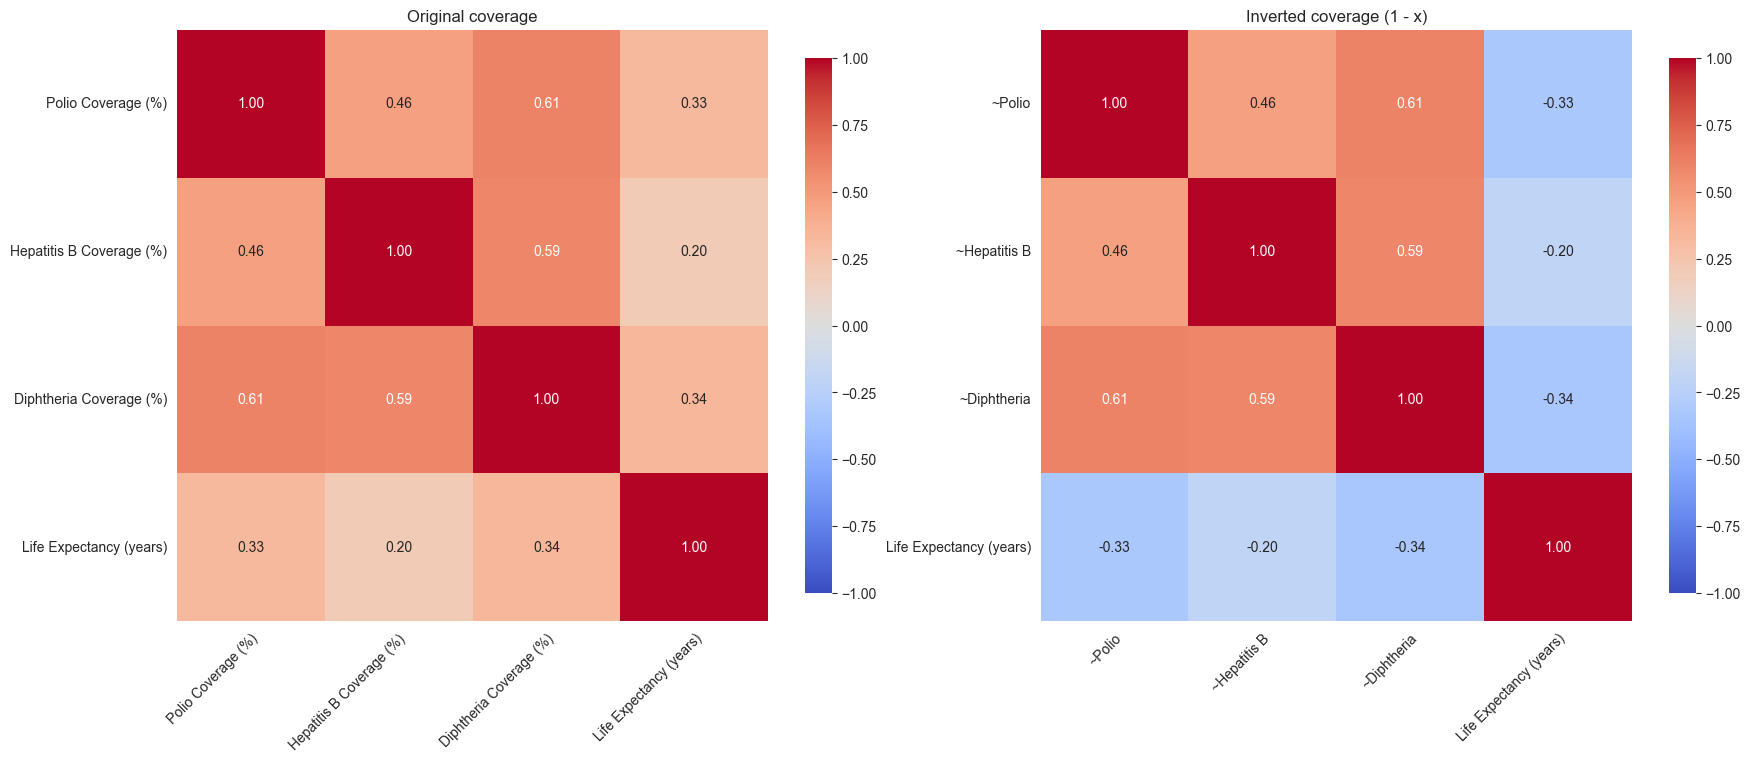

In [54]:
cov_cols = [LECol.POLIO, LECol.HEPATITIS_B, LECol.DIPHTHERIA]

df = le_ds.df.copy()
inv_cov_cols = [f"~{c}" for c in cov_cols]

base_corr = (
    le_ds.make_correlation_analyzer(
        columns=[*cov_cols, LECol.TARGET], include_target=True
    )
    .fit()
    .result()
)
inv_corr = (
    df.assign(**{col: 1 - df[col] for col in cov_cols})
    .rename(columns={c: f"~{c}" for c in cov_cols})
    .pipe(LifeExpectancyDataset)
    .make_correlation_analyzer(
        columns=[*inv_cov_cols, LECol.TARGET], include_target=True
    )
    .fit()
    .result()
)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plot_correlation_heatmap(base_corr, ax=axes[0])
axes[0].set_title("Original coverage")
plot_correlation_heatmap(inv_corr, ax=axes[1])
axes[1].set_title("Inverted coverage (1 - x)")
fig.show()
